In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import gsw
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    "figure.facecolor":  "white",  
    "savefig.facecolor": "white",  
})
import scipy.signal as signal

import src.helper as helper
from src.mooring import Mooring
from src.location import Location
from src.ctd_cast import CTDCast

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Get each mooring location

In [4]:
# load all 7 moorings as dataframes
list_of_moorings = helper.IO.load_pickle(name="../../data/mooring/list_of_moorings.pkl")

In [5]:
mooring_locations = [mooring.location for mooring in list_of_moorings]
mooring_locations

[Location(lat=-63.4032, lon=-52.287),
 Location(lat=-63.5145, lon=-51.6357),
 Location(lat=-63.656, lon=-50.8113),
 Location(lat=-63.7783, lon=-50.0897),
 Location(lat=-63.917, lon=-49.2682),
 Location(lat=-64.0665, lon=-48.3805),
 Location(lat=-64.2157, lon=-47.4903)]

# Load buoyancy frequency $N$


### Previous N calculations
63.41°S, 52.27°W: 1.25e-03  
63.48°S, 51.61°W: 1.06e-03  
63.67°S, 50.75°W: 1.28e-03  
63.73°S, 50.35°W: 1.32e-03  
63.88°S, 49.16°W: 1.39e-03  
64.08°S, 48.36°W: 1.36e-03  
64.28°S, 47.47°W: 4.40e-04  


* from *CTD/Even better N calculation*
* All values are in units of (rad/s)

In [6]:
N_table = pd.read_pickle("../../data/CTD/N_values.pkl") 
N_table

,mab,"(-63.40,-52.29)","(-63.51,-51.64)","(-63.66,-50.81)","(-63.78,-50.09)","(-63.92,-49.27)","(-64.07,-48.38)","(-64.22,-47.49)"
0,0,0.000314,0.000426,0.000399,0.000384,0.000498,0.001230,0.001011
1,1,0.000321,0.000439,0.000431,0.000397,0.000503,0.001247,0.001032
2,2,0.000329,0.000452,0.000465,0.000409,0.000508,0.001263,0.001053
3,3,0.000343,0.000465,0.000487,0.000422,0.000513,0.001279,0.001072
4,4,0.000356,0.000478,0.000504,0.000435,0.000517,0.001295,0.001092
...,...,...,...,...,...,...,...,...
595,595,0.001491,0.000848,0.000740,0.000661,0.000532,0.000503,0.000447
596,596,0.001491,0.000849,0.000738,0.000660,0.000534,0.000503,0.000447
597,597,0.001492,0.000851,0.000735,0.000659,0.000535,0.000505,0.000446
598,598,0.001493,0.000852,0.000735,0.000659,0.000537,0.000505,0.000445


In [7]:
N_table.iloc[:,2]

0      0.000426
1      0.000439
2      0.000452
3      0.000465
4      0.000478
         ...   
595    0.000848
596    0.000849
597    0.000851
598    0.000852
599    0.000854
Name: (-63.51,-51.64), Length: 600, dtype: float64

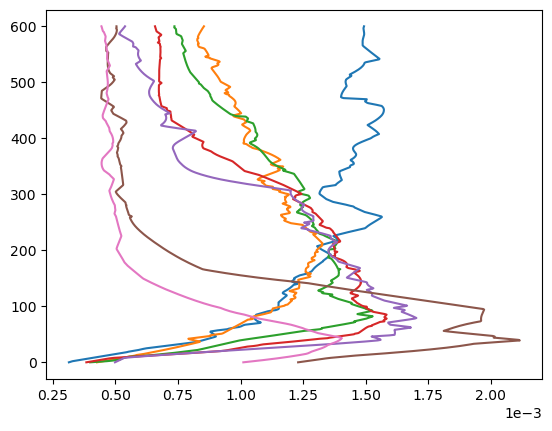

In [8]:
for i,_ in enumerate(N_table.columns):
    if i == 0: continue
    plt.plot(N_table.iloc[:,i],N_table.index)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [9]:
N_error_table = pd.read_pickle("../../data/CTD/N_std.pkl")  
N_error_table

,mab,"(-63.40,-52.29)","(-63.51,-51.64)","(-63.66,-50.81)","(-63.78,-50.09)","(-63.92,-49.27)","(-64.07,-48.38)","(-64.22,-47.49)"
0,0,0.000147,0.000266,0.000163,0.000183,0.000309,0.000328,0.000233
1,1,0.000149,0.000272,0.000176,0.000189,0.000312,0.000323,0.000241
2,2,0.000150,0.000275,0.000191,0.000194,0.000314,0.000317,0.000240
3,3,0.000152,0.000274,0.000188,0.000198,0.000315,0.000311,0.000238
4,4,0.000148,0.000274,0.000177,0.000201,0.000317,0.000304,0.000236
...,...,...,...,...,...,...,...,...
595,595,0.000351,0.000099,0.000043,0.000072,0.000059,0.000035,0.000019
596,596,0.000351,0.000100,0.000043,0.000072,0.000060,0.000035,0.000019
597,597,0.000351,0.000100,0.000044,0.000074,0.000061,0.000036,0.000019
598,598,0.000352,0.000100,0.000044,0.000073,0.000062,0.000036,0.000019


# Load energy levels

created by the script *calculate_available_energy_levels.py*

In [17]:
data = np.load("./results_data/results_available_energy.npz", allow_pickle = True) 
energy_levels = pd.DataFrame(data = {
    "lon":data["lon"], 
    "lat":data["lat"], 
    "rounded_depth": data["depth"],
    "rounded_mab": data["mab"],
    "barotropic":data["barotropic"],
    "continuum":data["continuum"],
    "available":data["available"],

})

In [18]:
energy_levels["rounded_depth"] = energy_levels["rounded_depth"].astype("int")

In [12]:
#energy_levels["energy_level"] = energy_levels["IW"] + energy_levels["barotropic"] + energy_levels["baroclinic"].fillna(0)

In [19]:
energy_levels

,lon,lat,rounded_depth,rounded_mab,barotropic,continuum,available
0,-52.2870,-63.4032,299,343,0.000807,0.000351,0.000351
1,-52.2870,-63.4032,505,137,0.000807,0.000560,0.000742
2,-52.2870,-63.4032,614,28,0.000807,0.000639,0.000844
3,-51.6357,-63.5145,1318,338,0.000423,0.000365,0.000476
4,-51.6357,-63.5145,1513,143,0.000423,0.000545,0.000593
5,-51.6357,-63.5145,1625,31,0.000423,0.000372,0.000372
6,-50.8113,-63.6560,2143,350,0.000237,0.000316,0.000457
7,-50.8113,-63.6560,2350,143,0.000237,0.000420,0.000563
8,-50.0897,-63.7783,2400,357,0.000190,0.000498,0.000507
9,-50.0897,-63.7783,2615,142,0.000190,0.000417,0.000442


energy_levels.plot(x = "lon", y = ["barotropic","baroclinic","IW"], marker = ".", ls = "None", ms = 30, figsize=(15, 8))
#plt.plot(energy_levels["lon"],energy_levels["energy_level"],".")

energy_levels.plot(x = "lon", y = ["barotropic","IW"], marker = ".", ls = "None", ms = 30, figsize=(15, 8))

In [14]:
energy_levels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lon             17 non-null     float64
 1   lat             17 non-null     float64
 2   rounded_depths  17 non-null     int64  
 3   rounded_mabs    17 non-null     int64  
 4   barotropic      17 non-null     float64
 5   continuum       17 non-null     float64
 6   available       17 non-null     float64
dtypes: float64(5), int64(2)
memory usage: 1.1 KB


# Add Meters Above Bottom dimension

data = np.load("data/max_depth_dict.npz", allow_pickle = True)
max_depth_dict = data["max_depth_dict"].item()

for index, row in energy_levels.iterrows():
    # get instrument depth in units of meter above the sea floor
    mab_of_measurement = int(max_depth_dict[mooring.location.lon]) - int(shallowest_depth) 
    #print("Shallow Test:",mab_of_measurement)

data = np.load("/home/ole/Desktop/Mooring_Analysis/notebooks/poster_temperature_data.npz")
mab_df = pd.DataFrame(data = {"lon": data["uv_lon"], "rounded_depths": data["uv_depth"], "mab": data["uv_mab"]})
mab_df["rounded_depths"] = mab_df["rounded_depths"].round(0).astype(int)
mab_df["mab"] = mab_df["mab"].round(0).astype(int)
mab_df

energy_levels = pd.merge(energy_levels, mab_df)
energy_levels

"""
energy_levels["max depth"] = np.nan
for value in set(energy_levels["lon"]):
    
    max_depth = energy_levels[energy_levels['lon']==value]['rounded_depths'].max() +5
    energy_levels.loc[energy_levels['lon'] == value, 'max depth'] = max_depth  
    print(value,max_depth)
    #energy_levels.query('lon==value')#['mab'] #= energy_levels["rounded_depths"]  df.query('lon==-52.2870')
"""    

In [21]:
#get N values and Errors at the geographic locations and depths of the energy levels

N_array = []
N_error_array = []

for index, row in energy_levels.iterrows():
    column_name = f"({row['lat']:.2f},{row['lon']:.2f})"
    #print(column_name)
    try:
        N_value = N_table.loc[N_table['mab'] == row["rounded_mab"], column_name].item()
        N_error = N_error_table.loc[N_error_table['mab'] == row["rounded_mab"], column_name].item()
    except ValueError:
        N_value = np.nan
        N_error = np.nan
    #print(N_error)
    N_array.append(N_value)
    N_error_array.append(N_error) 
    
energy_levels["N"] = N_array
energy_levels["N Error"] = N_error_array
energy_levels

,lon,lat,rounded_depth,rounded_mab,barotropic,continuum,available,N,N Error
0,-52.2870,-63.4032,299,343,0.000807,0.000351,0.000351,0.001410,0.000340
1,-52.2870,-63.4032,505,137,0.000807,0.000560,0.000742,0.001210,0.000124
2,-52.2870,-63.4032,614,28,0.000807,0.000639,0.000844,0.000679,0.000226
3,-51.6357,-63.5145,1318,338,0.000423,0.000365,0.000476,0.001132,0.000141
4,-51.6357,-63.5145,1513,143,0.000423,0.000545,0.000593,0.001233,0.000148
5,-51.6357,-63.5145,1625,31,0.000423,0.000372,0.000372,0.000786,0.000348
6,-50.8113,-63.6560,2143,350,0.000237,0.000316,0.000457,0.001146,0.000106
7,-50.8113,-63.6560,2350,143,0.000237,0.000420,0.000563,0.001367,0.000164
8,-50.0897,-63.7783,2400,357,0.000190,0.000498,0.000507,0.000972,0.000143
9,-50.0897,-63.7783,2615,142,0.000190,0.000417,0.000442,0.001479,0.000107


Text(0.5, 1.0, 'N in cpd')

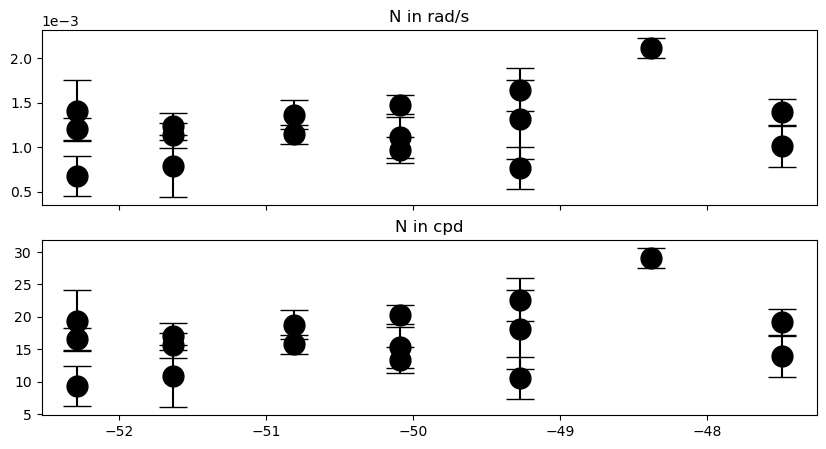

In [23]:
f,a = plt.subplots(nrows = 2, sharex = True, figsize = (10,5))
a[0].errorbar(energy_levels["lon"], energy_levels["N"], yerr = energy_levels["N Error"], capsize = 10, marker = ".", color = "k", ls = "None", ms = 30 )
a[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
a[1].errorbar(energy_levels["lon"], energy_levels["N"]/(2*np.pi)*86400, yerr = energy_levels["N Error"]/(2*np.pi)*86400, capsize = 10, marker = ".", color = "k", ls = "None", ms = 30 )
#a[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
a[0].set_title("N in rad/s")
a[1].set_title("N in cpd")

# Calculate Diffusivities

In [26]:
#get coriolis frequency at the geographic location of every mooring
energy_levels["coriolis frequency"] = energy_levels.apply(lambda row: helper.Constants.get_coriolis_frequency(row["lat"], unit = "rad/s"), axis=1)

# set negative energies to be NaN
#energy_levels.loc[energy_levels["baroclinic"] < 0, "baroclinic"] = np.NaN
energy_levels

,lon,lat,rounded_depth,rounded_mab,barotropic,continuum,available,N,N Error,coriolis frequency
0,-52.2870,-63.4032,299,343,0.000807,0.000351,0.000351,0.001410,0.000340,-0.000130
1,-52.2870,-63.4032,505,137,0.000807,0.000560,0.000742,0.001210,0.000124,-0.000130
2,-52.2870,-63.4032,614,28,0.000807,0.000639,0.000844,0.000679,0.000226,-0.000130
3,-51.6357,-63.5145,1318,338,0.000423,0.000365,0.000476,0.001132,0.000141,-0.000131
4,-51.6357,-63.5145,1513,143,0.000423,0.000545,0.000593,0.001233,0.000148,-0.000131
5,-51.6357,-63.5145,1625,31,0.000423,0.000372,0.000372,0.000786,0.000348,-0.000131
6,-50.8113,-63.6560,2143,350,0.000237,0.000316,0.000457,0.001146,0.000106,-0.000131
7,-50.8113,-63.6560,2350,143,0.000237,0.000420,0.000563,0.001367,0.000164,-0.000131
8,-50.0897,-63.7783,2400,357,0.000190,0.000498,0.000507,0.000972,0.000143,-0.000131
9,-50.0897,-63.7783,2615,142,0.000190,0.000417,0.000442,0.001479,0.000107,-0.000131


# use $K_\rho \approx \frac{\Gamma}{1+\Gamma} \mu_0 f_e \frac{(m_\star/N)^2E^2}{N^2}$ with 
   - $\Gamma = 0.2$
   - $\mu_0 = \frac{2}{3} $
   - $m_\star = 0.01\,$m$^{-1}$
   - $f_e = |f| \mathrm{arccosh}(\frac{N}{|f|}) $
   - $E^2 = \text{Wave continuum energy} $
   - $N = \text{bouyoancy frequency}$

def get_diapycnal_diffusivity(coriolis_frequency, buoyancy_frequency, energy_level):
    """
    eq. 18 from Olbers & Eden, 2013
    """
    MIXING_EFFICIENCY = 0.2
    MU_0 = 1 / 3 #value recommeded by Pollmann et al., 2017
    m_star = 0.01
    effective_coriolis_frequency = (
        np.abs(coriolis_frequency) * 
        np.arccosh(buoyancy_frequency / np.abs(coriolis_frequency))
    )
        
    diapycnal_diffusivity = (
        MIXING_EFFICIENCY / (1 + MIXING_EFFICIENCY)
        * MU_0
        * effective_coriolis_frequency
        * (m_star / buoyancy_frequency) ** 2
        * energy_level**2
        / buoyancy_frequency**2
    )

    return diapycnal_diffusivity

def get_error_of_diapycnal_diffusivity(coriolis_frequency, buoyancy_frequency, error_buoyancy_frequency, energy_level, error_energy_level):
    """
    eq. 18 from Olbers & Eden, 2013
    """
    MIXING_EFFICIENCY = 0.2
    MU_0 = 1 / 3 #value recommeded by Pollmann et al 2017
    m_star = 0.01

    arccosh_derivative = (
        1/(
            np.sqrt(buoyancy_frequency / np.abs(coriolis_frequency) - 1)
            *np.sqrt(buoyancy_frequency / np.abs(coriolis_frequency) + 1)
            )
        * m_star** 2
        * energy_level**2
        / buoyancy_frequency**4
        )
        
    exponent_derivative = (
        np.arccosh(buoyancy_frequency / np.abs(coriolis_frequency))
        * -4 * m_star** 2
        * energy_level**2
        / buoyancy_frequency**5
    )
    
    error_due_to_N = (
        MIXING_EFFICIENCY / (1 + MIXING_EFFICIENCY)
        * MU_0 * np.abs(coriolis_frequency)
        * (arccosh_derivative +  exponent_derivative)
        * error_buoyancy_frequency
    )
    
    effective_coriolis_frequency = (
        np.abs(coriolis_frequency) * 
        np.arccosh(buoyancy_frequency / np.abs(coriolis_frequency))
    )
        
    error_due_to_E = (
        MIXING_EFFICIENCY / (1 + MIXING_EFFICIENCY)
        * MU_0
        * effective_coriolis_frequency
        * 2 * m_star** 2
        * energy_level
        / buoyancy_frequency**4
        * error_energy_level
    )

    assert error_due_to_E == 0 or np.isnan(error_due_to_E)
    
    total_error = np.sqrt(error_due_to_N**2 + error_due_to_E**2)
    
    return total_error

energy_levels["K_rho_IW"] = energy_levels.apply(
    lambda row: get_diapycnal_diffusivity(
        coriolis_frequency = row['coriolis frequency'], 
        buoyancy_frequency = row['N'], 
        energy_level = row['IW'])
    , axis=1)

energy_levels["K_rho_IW_error"] = energy_levels.apply(
    lambda row: get_error_of_diapycnal_diffusivity(
        coriolis_frequency = row['coriolis frequency'], 
        buoyancy_frequency = row['N'], 
        error_buoyancy_frequency = row['N Error'],
        energy_level = row['IW'],
        error_energy_level = 0)
    , axis=1)

energy_levels["K_rho"] = energy_levels.apply(
    lambda row: get_diapycnal_diffusivity(
        coriolis_frequency = row['coriolis frequency'], 
        buoyancy_frequency = row['N'], 
        energy_level = row['IW'] + row['baroclinic'])
    , axis=1)

energy_levels["K_rho_error"] = energy_levels.apply(
    lambda row: get_error_of_diapycnal_diffusivity(
        coriolis_frequency = row['coriolis frequency'], 
        buoyancy_frequency = row['N'], 
        error_buoyancy_frequency = row['N Error'],
        energy_level = row['IW'] + row['baroclinic'],
        error_energy_level = 0)
    , axis=1)

#energy_levels["K_rho magnitude"] = np.floor(np.log10(energy_levels["K_rho"]))
#df.style.format(formatter={('K_rho', 'energy_level', 'coriolis frequency', 'mean_N'): lambda x: "$ {:,.1e}.format"})
#pd.set_option('display.float_format', '{:.3e}'.format)
energy_levels

In [27]:
def get_dissipation_rate(coriolis_frequency, buoyancy_frequency, energy_level):
    """
    eq. 18 from Olbers & Eden, 2013
    """
    MIXING_EFFICIENCY = 0.2
    MU_0 = 1 / 3 #value recommeded by Pollmann et al., 2017
    m_star = 0.01
    effective_coriolis_frequency = (
        np.abs(coriolis_frequency) * 
        np.arccosh(buoyancy_frequency / np.abs(coriolis_frequency))
    )
        
    dissipation_rate = (
        1 / (1 + MIXING_EFFICIENCY)
        * MU_0
        * effective_coriolis_frequency
        * (m_star) ** 2
        * energy_level**2
        / buoyancy_frequency**2
    )

    return dissipation_rate

In [27]:
def get_error_of_dissipation_rate(coriolis_frequency, buoyancy_frequency, error_buoyancy_frequency, energy_level, error_energy_level):
    """
    eq. 18 from Olbers & Eden, 2013
    """
    MIXING_EFFICIENCY = 0.2
    MU_0 = 1 / 3 #value recommeded by Pollmann et al 2017
    m_star = 0.01

    arccosh_N_derivative = (
        1/(
            np.sqrt(buoyancy_frequency / np.abs(coriolis_frequency) - 1)
            *np.sqrt(buoyancy_frequency / np.abs(coriolis_frequency) + 1)
            )
        * m_star** 2
        * energy_level**2
        / buoyancy_frequency**2
        )
        
    exponent_N_derivative = (
        np.arccosh(buoyancy_frequency / np.abs(coriolis_frequency))
        * -2 * m_star** 2
        * energy_level**2
        / buoyancy_frequency**3
    )
    
    error_due_to_N = (
        1/ (1 + MIXING_EFFICIENCY)
        * MU_0 * np.abs(coriolis_frequency)
        * (arccosh_N_derivative +  exponent_N_derivative)
        * error_buoyancy_frequency
    )
    
    effective_coriolis_frequency = (
        np.abs(coriolis_frequency) * 
        np.arccosh(buoyancy_frequency / np.abs(coriolis_frequency))
    )
        
    error_due_to_E = (
        1 / (1 + MIXING_EFFICIENCY)
        * MU_0
        * effective_coriolis_frequency
        * 2 * m_star** 2
        * energy_level
        / (buoyancy_frequency**2)
        * error_energy_level
    )

    assert error_due_to_E == 0 or np.isnan(error_due_to_E)
    
    total_error = np.sqrt(error_due_to_N**2 + error_due_to_E**2)
    
    return total_error

# Stopped Here!

* Calculate dissipation rates
* come up with Delta E
* new figures
* new comparison figures

In [28]:
energy_levels["eps_IW"] = energy_levels.apply(
    lambda row: get_dissipation_rate(
        coriolis_frequency = row['coriolis frequency'], 
        buoyancy_frequency = row['N'], 
        energy_level = row['IW'])
    , axis=1)

energy_levels["eps_IW_error"] = energy_levels.apply(
    lambda row: get_error_of_dissipation_rate(
        coriolis_frequency = row['coriolis frequency'], 
        buoyancy_frequency = row['N'], 
        error_buoyancy_frequency = row['N Error'],
        energy_level = row['IW'],
        error_energy_level = 0)
    , axis=1)

energy_levels["eps"] = energy_levels.apply(
    lambda row: get_dissipation_rate(
        coriolis_frequency = row['coriolis frequency'], 
        buoyancy_frequency = row['N'], 
        energy_level = row['IW'] + row['baroclinic'])
    , axis=1)

energy_levels["eps_error"] = energy_levels.apply(
    lambda row: get_error_of_dissipation_rate(
        coriolis_frequency = row['coriolis frequency'], 
        buoyancy_frequency = row['N'], 
        error_buoyancy_frequency = row['N Error'],
        energy_level = row['IW'] + row['baroclinic'],
        error_energy_level = 0)
    , axis=1)

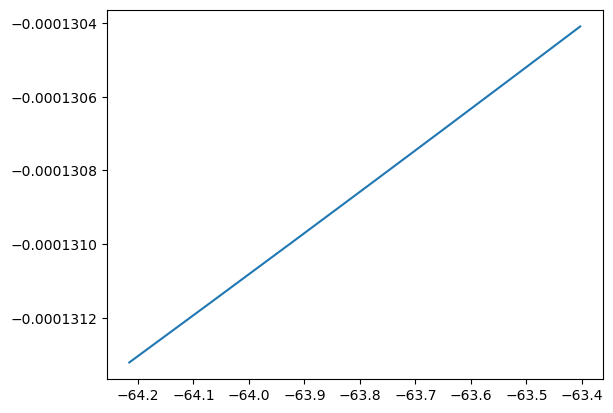

In [29]:
plt.plot(energy_levels["lat"],energy_levels["coriolis frequency"])

In [30]:
#pd.reset_option('display.float_format')

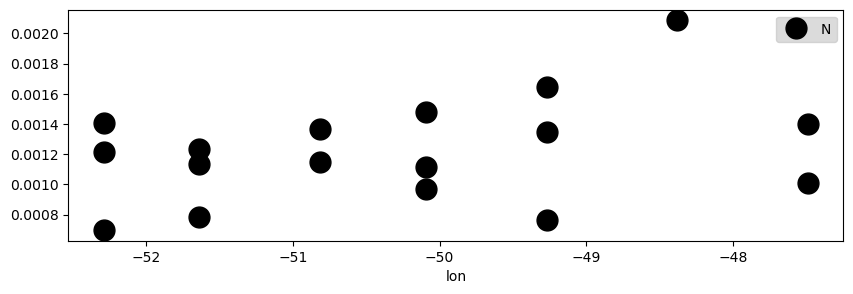

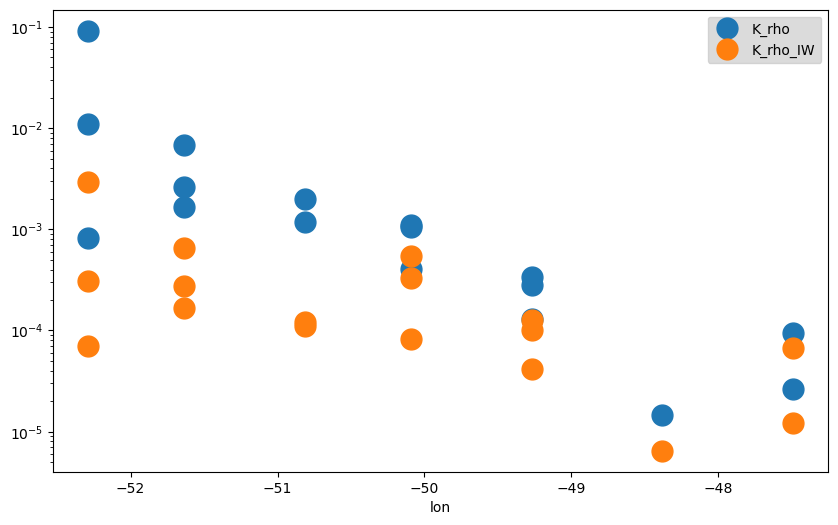

In [31]:
energy_levels.plot(x = "lon", y = "N", marker = ".", color = "k", ls = "None", ms = 30, figsize=(10, 3)).legend(loc='upper right', facecolor = "lightgray")
energy_levels.plot(x = "lon", y = ["K_rho","K_rho_IW"], marker = ".", ls = "None", logy = True, ms = 30, figsize=(10, 6)).legend(loc='best', facecolor = "lightgray")

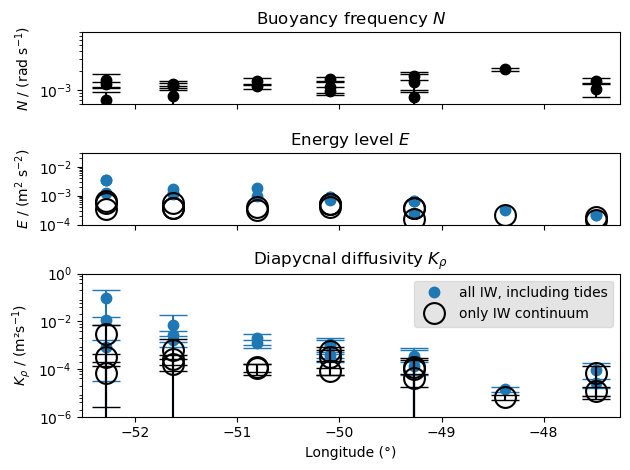

In [32]:
f,a = plt.subplots(3, sharex = True, height_ratios = [1,1,2])#, figsize = (16,6))
#f.set_size_inches(8,4)
a[0].semilogy(energy_levels["lon"], energy_levels["N"], marker = ".", color = "k", ls = "None", ms = 15, nonpositive = 'clip')
a[0].errorbar(energy_levels["lon"], energy_levels["N"], yerr = energy_levels["N Error"], capsize = 10, fmt = "None", color = "k")

a[1].semilogy(energy_levels["lon"], energy_levels["IW"] + energy_levels["baroclinic"], marker = ".", c = "tab:blue", ls = "None", ms = 15, label = "all IW, including baroclinic tides")
#a[1].errorbar(energy_levels["lon"], energy_levels["IW"], yerr = energy_levels["N Error"], capsize = 10, fmt = "None", color = "tab:blue")

a[1].semilogy(energy_levels["lon"], energy_levels["IW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 30, label = "only IW continuum")
#a[1].errorbar(energy_levels["lon"], energy_levels["IW"], yerr = energy_levels["N Error"], capsize = 10, fmt = "None", color = "k")

a[2].semilogy(energy_levels["lon"], energy_levels["K_rho"], marker = ".", c = "tab:blue", ls = "None", ms = 15, label = "all IW, including tides")
a[2].errorbar(energy_levels["lon"], energy_levels["K_rho"], yerr = energy_levels["K_rho_error"], capsize = 10, fmt = "None", color = "tab:blue")

a[2].semilogy(energy_levels["lon"], energy_levels["K_rho_IW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 30, label = "only IW continuum")
a[2].errorbar(energy_levels["lon"], energy_levels["K_rho_IW"], yerr = energy_levels["K_rho_IW_error"], capsize = 10, fmt = "None", color = "k")

a[0].set_ylabel(r"$N$ / (rad s$^{-1}$)")
a[1].set_ylabel(r"$E$ / (m$^2$ s$^{-2}$)")
a[2].set_ylabel(r"$K_\rho$ / (m²s$^{-1}$)")

a[0].set_ylim(6e-4,8e-3)
a[1].set_ylim(1e-4,3e-2)
a[2].set_ylim(1e-6,1)

a[0].set_title(r"Buoyancy frequency $N$")
a[1].set_title(r"Energy level $E$")
a[2].set_title(r"Diapycnal diffusivity $K_\rho$")
import matplotlib
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=6) 
a[2].yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
a[2].yaxis.set_minor_locator(locmin)
a[2].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
a[2].set_xlabel("Longitude (°)")

#a[1].legend(loc = "best", framealpha = 0.6, facecolor = "lightgray")
a[2].legend(loc = "best", framealpha = 0.6, facecolor = "lightgray")
import os
path = os.getcwd()
#help.Plot.path_as_footnote(fig = f, path = path)
f.tight_layout()
help.IO.save_as_pickle((f,a), name= "./data/K_rho_fig")
f.savefig("./figures/Krho_calculation", dpi = 300)

In [33]:
#from IPython.display import Image, display;   
#display(Image(filename='./Krho_calculation_new.png', width = 1000))

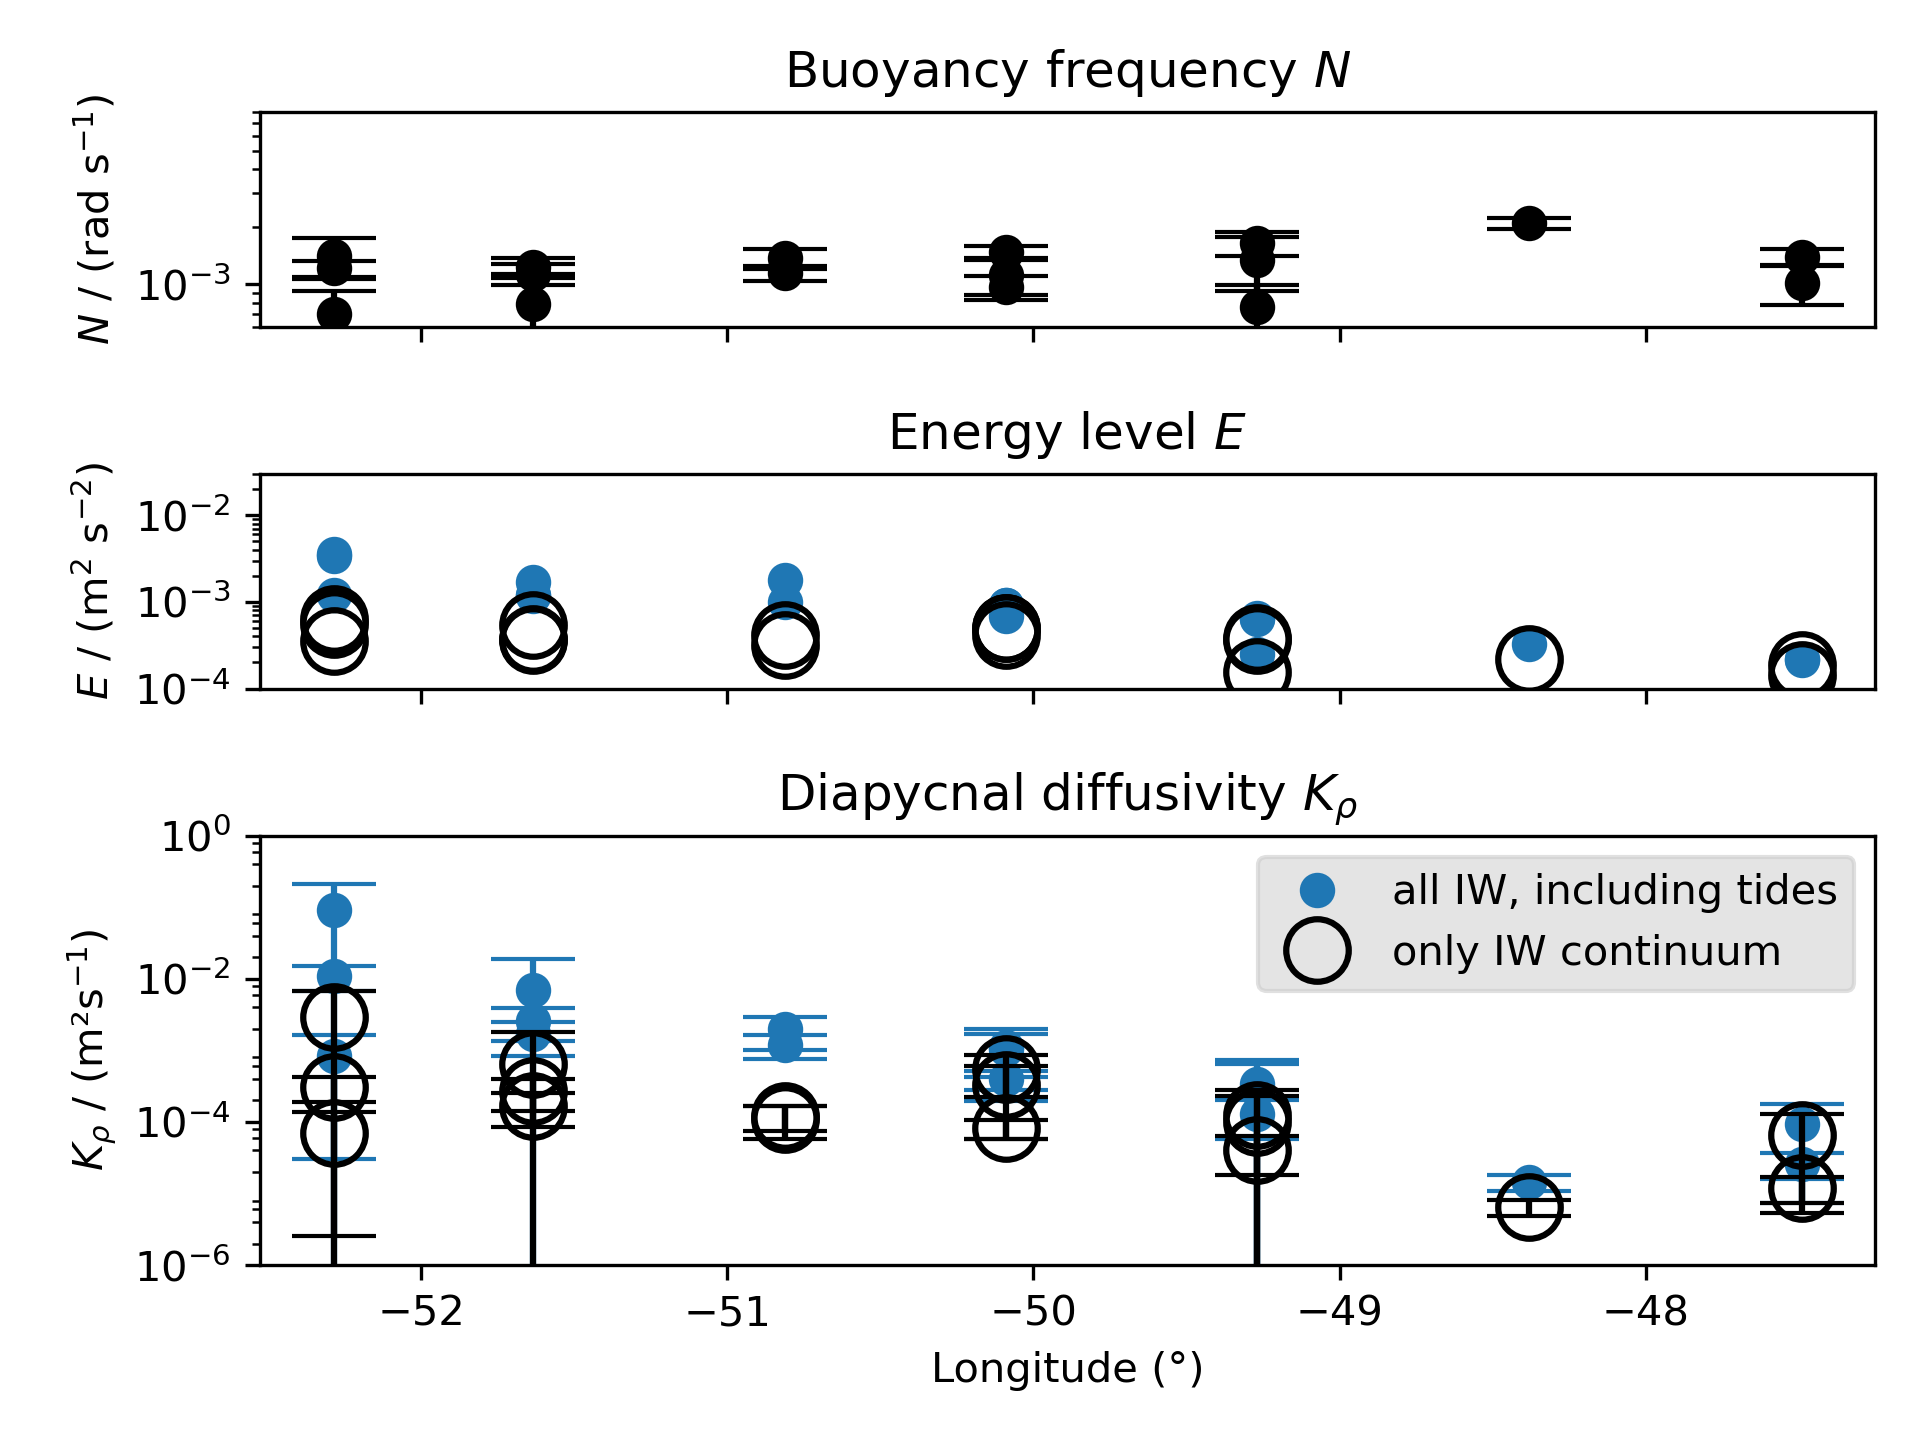

In [34]:
from IPython.display import Image, display;   
display(Image(filename='./figures/Krho_calculation.png', width = 1000))

# Now with shifted data points

In [35]:
nr_of_points = 3
xstep = 0.2
a = np.arange(0,nr_of_points*xstep, xstep) 
if nr_of_points%2 != 0 and len(a)!= 1:
    a = a[:-1]
a = a - np.median(a)
print(a)

[-0.2  0.   0.2]


-52.287
2     29
1    138
0    343
Name: mab, dtype: int64
[-0.1  0.   0.1]
-51.6357
5     31
4    143
3    338
Name: mab, dtype: int64
[-0.1  0.   0.1]
-50.0897
10     33
9     143
8     358
Name: mab, dtype: int64
[-0.1  0.   0.1]
-50.8113
7    143
6    350
Name: mab, dtype: int64
[-0.05  0.05]
-49.2682
13     32
12     91
11    354
Name: mab, dtype: int64
[-0.1  0.   0.1]
-48.3805
14    41
Name: mab, dtype: int64
[0.]
-47.4903
16     0
15    40
Name: mab, dtype: int64
[-0.05  0.05]


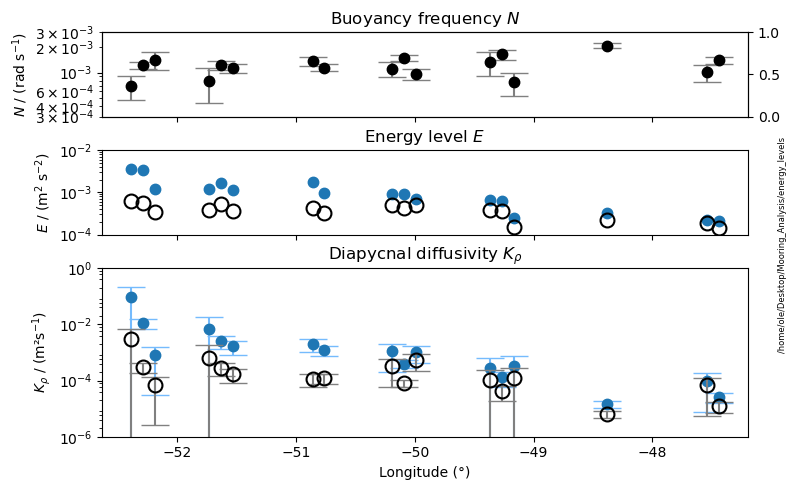

In [36]:
#find out how many points per location will be drawn
groups = energy_levels.groupby("lon")
f,a = plt.subplots(3, sharex = True, height_ratios = [1,1,2], figsize = (8,5))
for lon in set(energy_levels["lon"]):
    print(lon)
    group = groups.get_group(lon)
    group = group.sort_values("mab")
    print(group["mab"])
    nr_of_points = len(group.index)

    #to declutter the figure, points are shifted centered around the original x value. 
    # magintude of the shift in units of the x coordinate
    xstep = 0.1
    xshift = np.arange(0,nr_of_points*xstep, xstep) 
    #disticntion between 1 point (no shifts), odd and even points
    if nr_of_points%2 != 0 and len(xshift)!= 1:
        xshift = xshift[:-1]
    #centering    
    xshift = xshift - np.median(xshift)
    
    print(xshift)
    #print(group)
    a[0].errorbar(group["lon"] + xshift, group["N"], yerr = group["N Error"], capsize = 10, fmt = "None", color = "gray")
    a[0].semilogy(group["lon"] + xshift, group["N"], marker = ".", color = "k", ls = "None", ms = 15, nonpositive = 'clip')


    #a[1].errorbar(group["lon"], group["IW"], yerr = group["N Error"], capsize = 10, fmt = "None", color = "tab:blue")
    #a[1].errorbar(group["lon"], group["IW"], yerr = group["N Error"], capsize = 10, fmt = "None", color = "k")
    
    if not group["baroclinic"].isnull().values.all():
        a[1].semilogy(group["lon"] + xshift, group["IW"] + group["baroclinic"], marker = ".", c = "tab:blue", ls = "None", ms = 15, label = "all IW, including baroclinic tides")

        a[2].errorbar(group["lon"] + xshift, group["K_rho"], yerr = group["K_rho_error"], capsize = 10, fmt = "None", color = "xkcd:sky blue")
        a[2].semilogy(group["lon"] + xshift, group["K_rho"], marker = ".", c = "tab:blue", ls = "None", ms = 15, label = "all IW, including tides")


    a[1].semilogy(group["lon"] + xshift, group["IW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20, label = "only IW continuum")
    
    a[2].errorbar(group["lon"] + xshift, group["K_rho_IW"], yerr = group["K_rho_IW_error"], capsize = 10, fmt = "None", color = "gray")
    a[2].semilogy(group["lon"] + xshift, group["K_rho_IW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20, label = "only IW continuum")

    
a[0].set_ylabel(r"$N$ / (rad s$^{-1}$)")
a[1].set_ylabel(r"$E$ / (m$^2$ s$^{-2}$)")
a[2].set_ylabel(r"$K_\rho$ / (m²s$^{-1}$)")

a[0].set_ylim(0.3e-3,3e-3)
rad_per_s_to_CPD = 86400 / (2*np.pi)
ax_CPD = a[0].twinx()
mn, mx = a[0].get_ylim()
#ax_CPD.set_ylim(mn*rad_per_s_to_CPD, mx*rad_per_s_to_CPD)
#ax_CPD.set_ylabel('N / cpd')
#ax_CPD.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


a[1].set_ylim(1e-4,1e-2)
a[2].set_ylim(1e-6,1)

a[0].set_title(r"Buoyancy frequency $N$")
a[1].set_title(r"Energy level $E$")
a[2].set_title(r"Diapycnal diffusivity $K_\rho$")
import matplotlib
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=6) 
a[2].yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
a[2].yaxis.set_minor_locator(locmin)
a[2].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
a[2].set_xlabel("Longitude (°)")

#a[1].legend(loc = "best", framealpha = 0.6, facecolor = "lightgray")
#a[2].legend(loc = "best", framealpha = 0.6, facecolor = "lightgray")
import os
path = os.getcwd()
help.Plot.path_as_footnote(fig = f, path = path)
f.tight_layout()
f.subplots_adjust(hspace=0.3) 
help.IO.save_as_pickle((f,a), name= "./data/K_rho_fig")
f.savefig("./figures/Krho_calculation", dpi = 300)

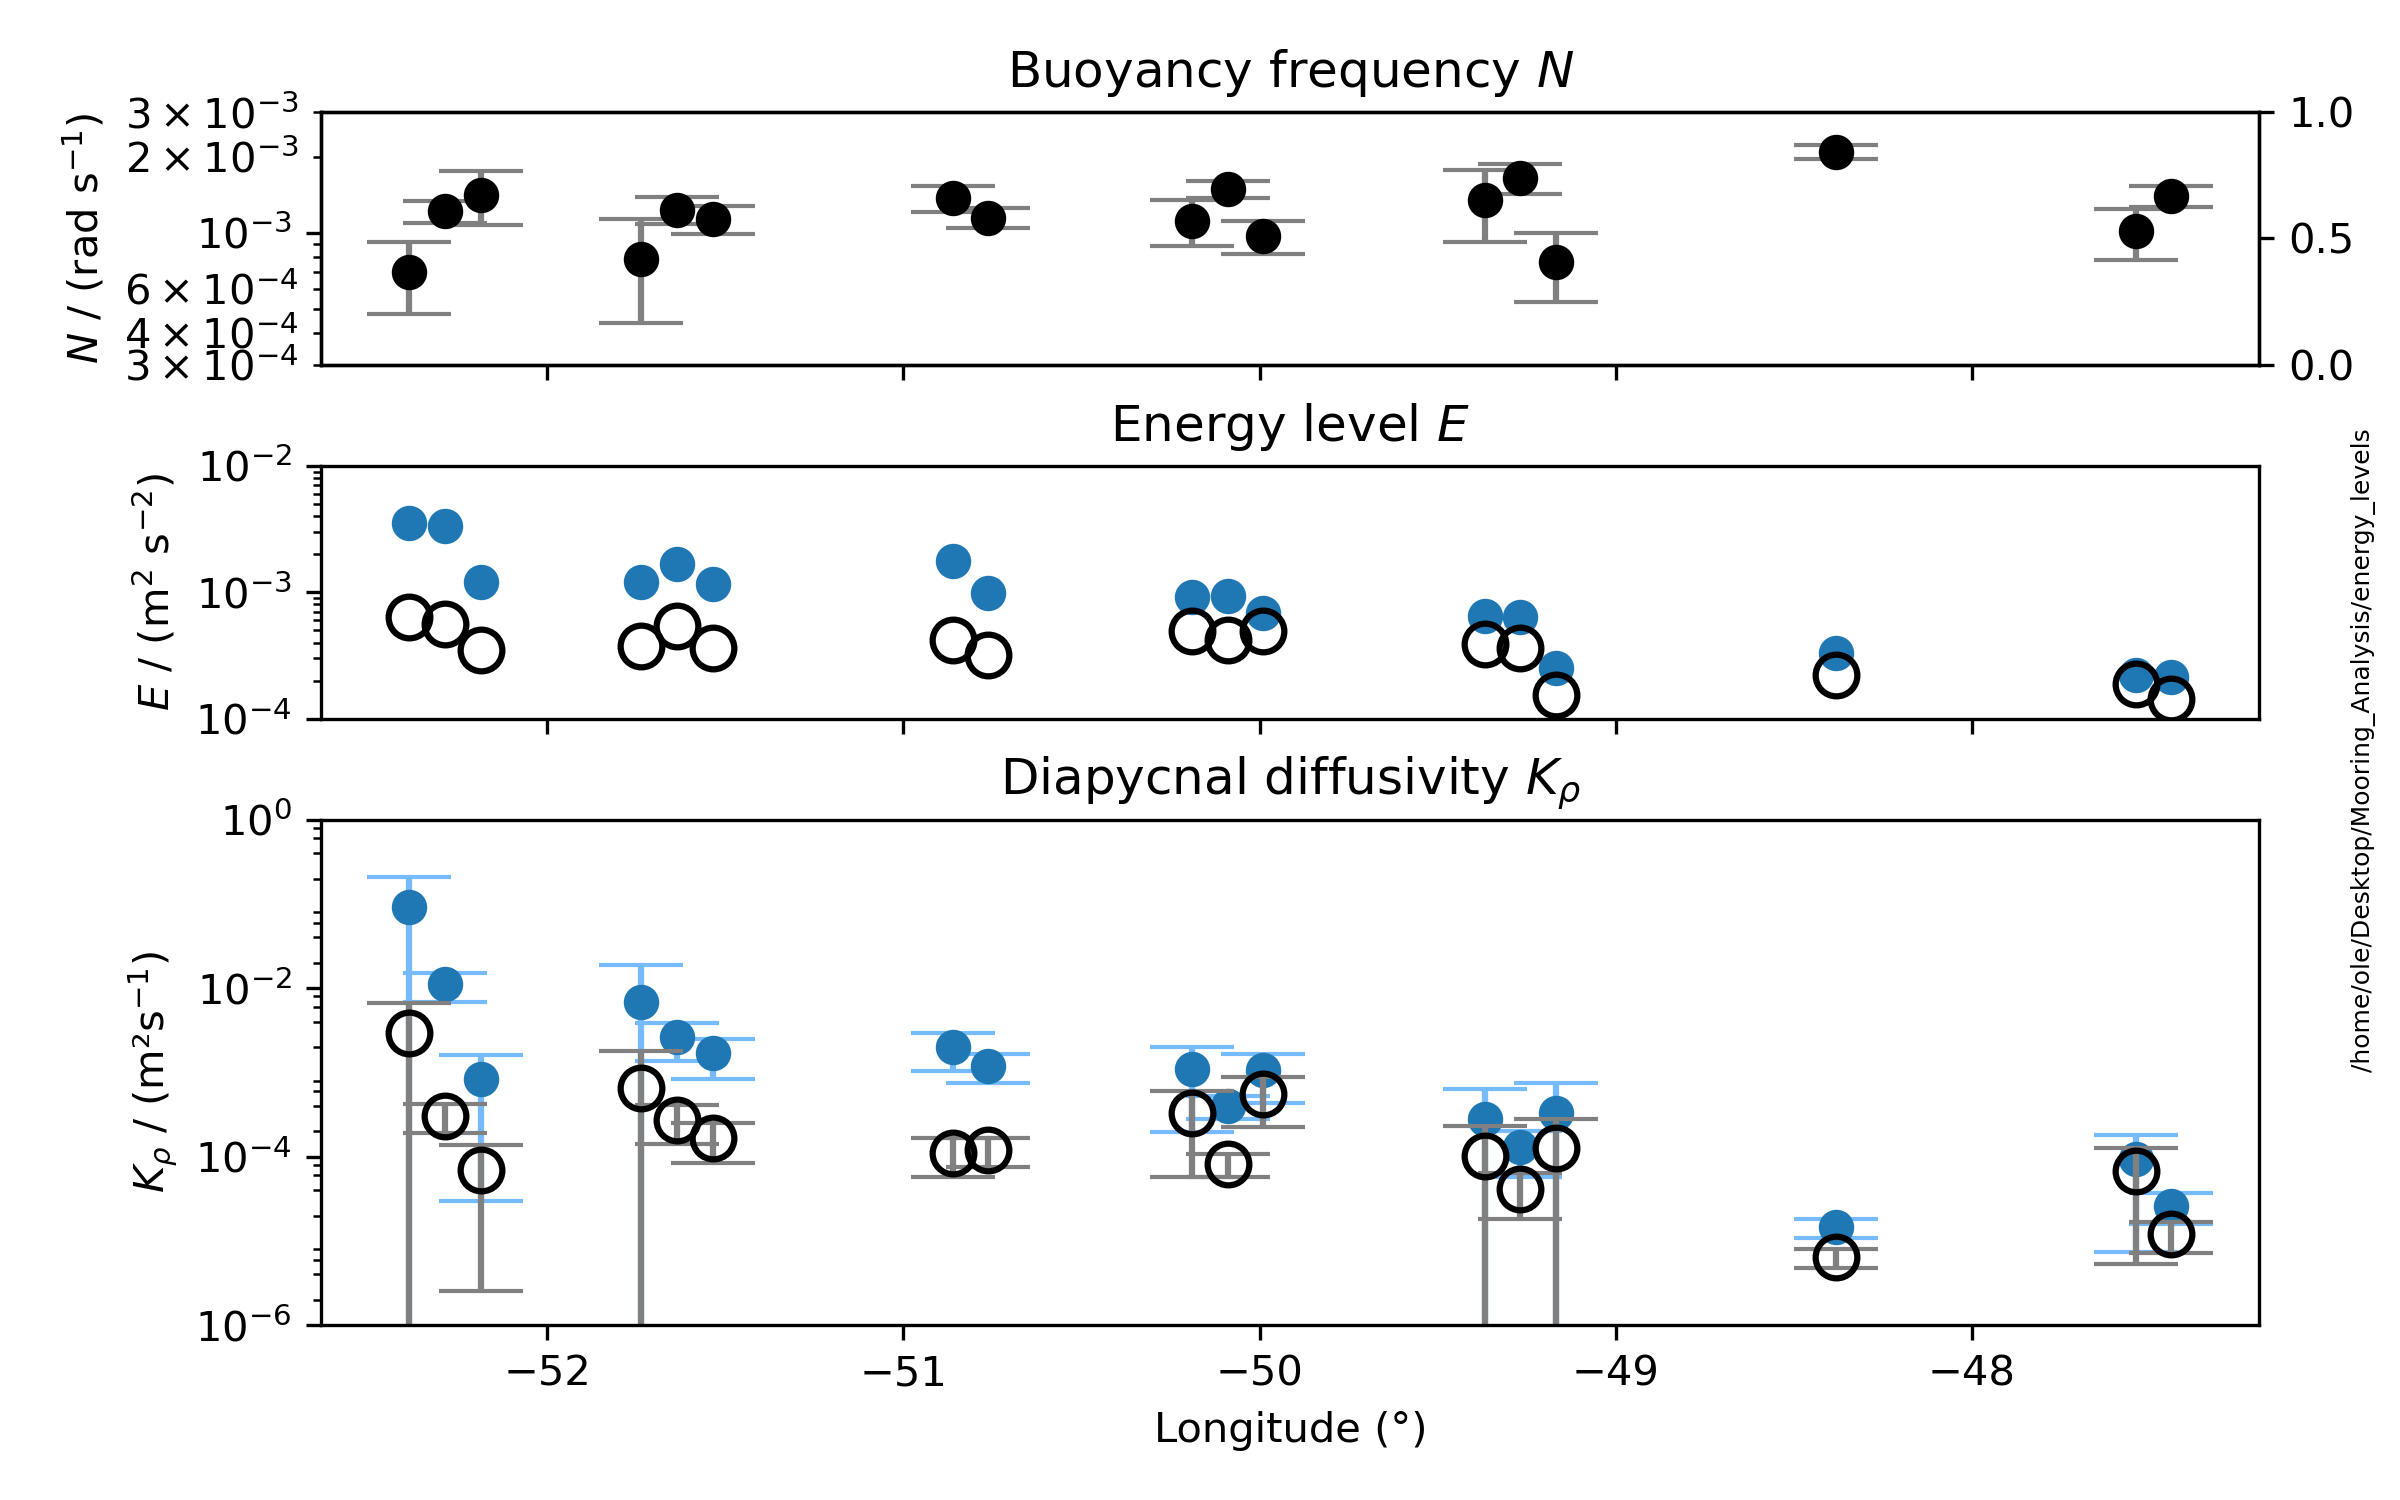

In [37]:
from IPython.display import Image, display;   
display(Image(filename='./figures/Krho_calculation.png', width = 1000))   
#display(Image(filename='./Krho_fig.svg', width = 1000))

-52.287
-51.6357
-50.0897
-50.8113
-49.2682
-48.3805
-47.4903


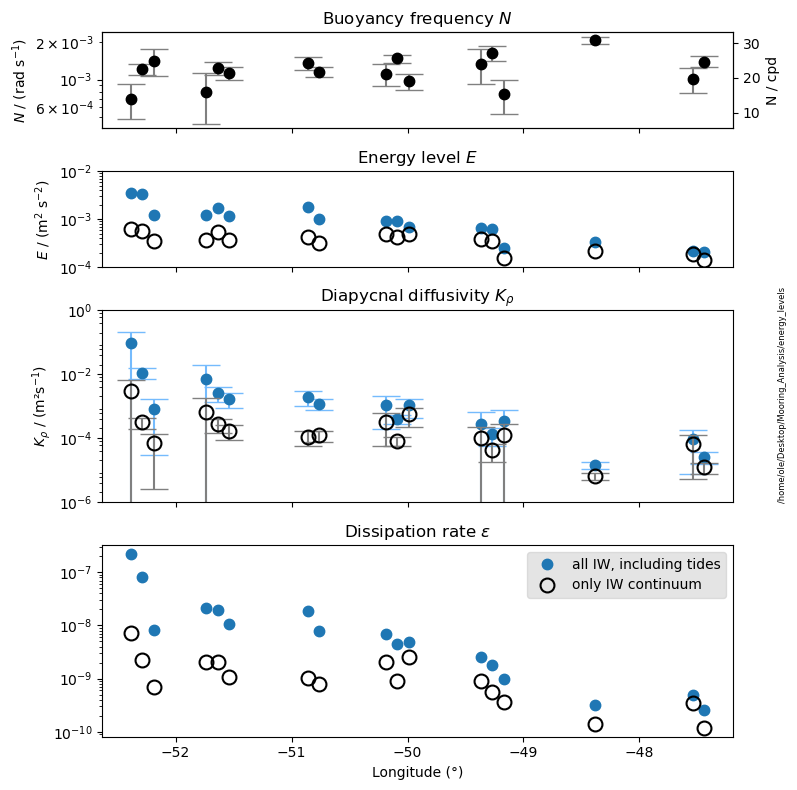

In [38]:
#find out how many points per location will be drawn
groups = energy_levels.groupby("lon")
f,a = plt.subplots(nrows = 4, sharex = True, height_ratios = [1,1,2,2], figsize = (8,8))
for lon in set(energy_levels["lon"]):
    print(lon)
    group = groups.get_group(lon)
    group = group.sort_values("mab")
    nr_of_points = len(group.index)

    #to declutter the figure, points are shifted centered around the original x value. 
    # magnitude of the shift in units of the x coordinate
    xstep = 0.1
    xshift = np.arange(0,nr_of_points*xstep, xstep) 
    #distinction between 1 point (no shifts), odd and even points
    if nr_of_points%2 != 0 and len(xshift)!= 1:
        xshift = xshift[:-1]
    #centering    
    xshift = xshift - np.median(xshift)
    
    #print(xshift)
    #print(group)
    a[0].errorbar(group["lon"] + xshift, group["N"], yerr = group["N Error"], capsize = 10, fmt = "None", color = "gray")
    a[0].semilogy(group["lon"] + xshift, group["N"], marker = ".", color = "k", ls = "None", ms = 15, nonpositive = 'clip')


    #a[1].errorbar(group["lon"], group["IW"], yerr = group["N Error"], capsize = 10, fmt = "None", color = "tab:blue")
    #a[1].errorbar(group["lon"], group["IW"], yerr = group["N Error"], capsize = 10, fmt = "None", color = "k")
    
    # plot baroclinic values if they exist
    if not group["baroclinic"].isnull().values.all():
        a[1].semilogy(group["lon"] + xshift, group["IW"] + group["baroclinic"], marker = ".", c = "tab:blue", ls = "None", ms = 15, label = "all IW, including baroclinic tides")

        a[2].errorbar(group["lon"] + xshift, group["K_rho"], yerr = group["K_rho_error"], capsize = 10, fmt = "None", color = "xkcd:sky blue")
        a[2].semilogy(group["lon"] + xshift, group["K_rho"], marker = ".", c = "tab:blue", ls = "None", ms = 15, label = "all IW, including tides")


    a[1].semilogy(group["lon"] + xshift, group["IW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20, label = "only IW continuum")
    
    a[2].errorbar(group["lon"] + xshift, group["K_rho_IW"], yerr = group["K_rho_IW_error"], capsize = 10, fmt = "None", color = "gray")
    a[2].semilogy(group["lon"] + xshift, group["K_rho_IW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20, label = "only IW continuum")

    # label = "all IW, including tides"
    a[3].semilogy(group["lon"] + xshift, group["eps"], marker = ".", c = "tab:blue", ls = "None", ms = 15)
    
    #label = "only IW continuum"
    a[3].semilogy(group["lon"] + xshift, group["eps_IW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20)
    
a[0].set_ylabel(r"$N$ / (rad s$^{-1}$)")
a[1].set_ylabel(r"$E$ / (m$^2$ s$^{-2}$)")
a[2].set_ylabel(r"$K_\rho$ / (m²s$^{-1}$)")

#a[0].set_ylim(6e-4,8e-3)
rad_per_s_to_CPD = 86400 / (2*np.pi)
ax_CPD = a[0].twinx()
mn, mx = a[0].get_ylim()
ax_CPD.set_ylim(mn*rad_per_s_to_CPD, mx*rad_per_s_to_CPD)
ax_CPD.set_ylabel('N / cpd')
#ax_CPD.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


a[1].set_ylim(1e-4,1e-2)
a[2].set_ylim(1e-6,1)
ylims = a[3].get_ylim()
# for the legend
a[3].semilogy(group["lon"] + xshift, 1e10*group["K_rho"]/0.2*group["N"]**2, marker = ".", c = "tab:blue", ls = "None", ms = 15, label = "all IW, including tides")
a[3].semilogy(group["lon"] + xshift, 1e10*group["K_rho_IW"]/0.2*group["N"]**2, marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20, label = "only IW continuum")
a[3].set_ylim(ylims)
    
    
    
a[0].set_title(r"Buoyancy frequency $N$")
a[1].set_title(r"Energy level $E$")
a[2].set_title(r"Diapycnal diffusivity $K_\rho$")
a[3].set_title(r"Dissipation rate $\varepsilon$")
import matplotlib
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=6) 
a[2].yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
a[2].yaxis.set_minor_locator(locmin)
a[2].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
a[3].set_xlabel("Longitude (°)")

#a[1].legend(loc = "best", framealpha = 0.6, facecolor = "lightgray")
#a[2].legend(loc = "best", framealpha = 0.6, facecolor = "lightgray")
a[3].legend(loc = "best", framealpha = 0.6, facecolor = "lightgray")
import os
path = os.getcwd()
help.Plot.path_as_footnote(fig = f, path = path)
f.tight_layout()
f.subplots_adjust(hspace=0.3) 
#help.IO.save_as_pickle((f,a), name= "./data/K_rho_fig")
f.savefig("./figures/Eps_IW_calculation", dpi = 300)

-52.287
-51.6357
-50.0897
-50.8113
-49.2682
-48.3805
-47.4903


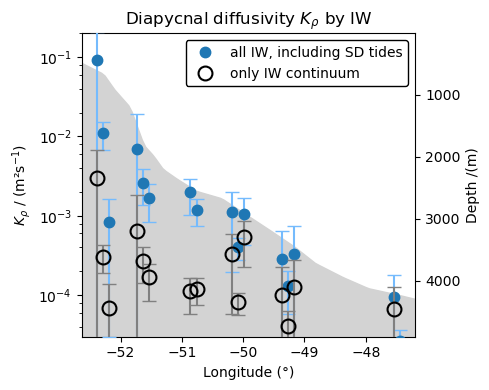

In [39]:
data = np.load("./data/transect_bathymetry.npz")
bat_depth = data["depth"]
bat_lon = data["lon"]


#find out how many points per location will be drawn
groups = energy_levels.groupby("lon")
f,a = plt.subplots(nrows = 1, sharex = True, figsize = (5,4))
for lon in set(energy_levels["lon"]):
    print(lon)
    group = groups.get_group(lon)
    group = group.sort_values("mab")
    nr_of_points = len(group.index)

    #to declutter the figure, points are shifted centered around the original x value. 
    # magnitude of the shift in units of the x coordinate
    xstep = 0.1
    xshift = np.arange(0,nr_of_points*xstep, xstep) 
    #distinction between 1 point (no shifts), odd and even points
    if nr_of_points%2 != 0 and len(xshift)!= 1:
        xshift = xshift[:-1]
    #centering    
    xshift = xshift - np.median(xshift)
       
    if not group["baroclinic"].isnull().values.all():
        a.errorbar(group["lon"] + xshift, group["K_rho"], yerr = group["K_rho_error"], capsize = 5, fmt = "None", color = "xkcd:sky blue", zorder = 10)
        a.semilogy(group["lon"] + xshift, group["K_rho"], marker = ".", c = "tab:blue", ls = "None", ms = 15, zorder = 10)  
    a.errorbar(group["lon"] + xshift, group["K_rho_IW"], yerr = group["K_rho_IW_error"], capsize = 5, fmt = "None", color = "gray", zorder = 10)
    a.semilogy(group["lon"] + xshift, group["K_rho_IW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20, zorder = 10)
    

a.set_ylabel(r"$K_\rho$ / (m²s$^{-1}$)")

# for the legend
a.semilogy(group["lon"] + xshift, 1e10*group["K_rho"]/0.2*group["N"]**2, marker = ".", c = "tab:blue", ls = "None", ms = 15, label = "all IW, including SD tides")
a.semilogy(group["lon"] + xshift, 1e10*group["K_rho_IW"]/0.2*group["N"]**2, marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20, label = "only IW continuum")
a.set_ylim(3e-5,2e-1)
    
a.set_title(r"Diapycnal diffusivity $K_\rho$ by IW")
import matplotlib
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=6) 
a.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
a.yaxis.set_minor_locator(locmin)
a.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
a.set_xlabel("Longitude (°)")

a.legend(loc = "best", framealpha = 1, edgecolor = "k")#, facecolor = "lightgray")

a2 = a.twinx()
a2.invert_yaxis()
xlim = a.get_xlim()
a2.fill_between(bat_lon,np.ones(len(bat_lon))*4900,bat_depth, color = "lightgrey")
a2.set_xlim(xlim)
a2.set_ylim(4900,10)
a2.set_zorder(a.get_zorder()-1)
a.set_frame_on(False)
a2.set_ylabel("Depth /(m)")
    
f.tight_layout()    
#help.IO.save_as_pickle((f,a), name= "./data/K_rho_fig")
f.savefig("./figures/Krho_IW_poster", dpi = 800)

-52.287
-51.6357
-50.0897
-50.8113
-49.2682
-48.3805
-47.4903


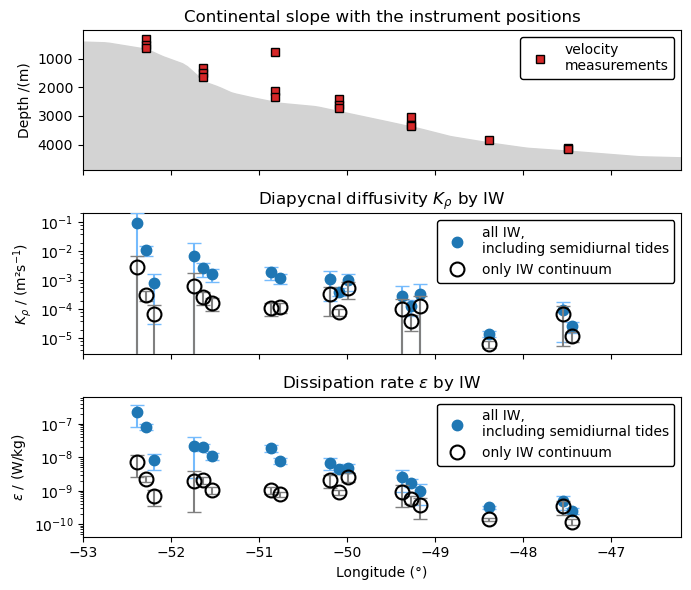

In [40]:
data = np.load("./data/transect_bathymetry.npz")
bat_depth = data["depth"]
bat_lon = data["lon"]


#find out how many points per location will be drawn
groups = energy_levels.groupby("lon")
fig,ax = plt.subplots(nrows = 3, sharex = True, figsize = (7,6))
for lon in set(energy_levels["lon"]):
    print(lon)
    group = groups.get_group(lon)
    group = group.sort_values("mab")
    nr_of_points = len(group.index)

    #to declutter the figure, points are shifted centered around the original x value. 
    # magnitude of the shift in units of the x coordinate
    xstep = 0.1
    xshift = np.arange(0,nr_of_points*xstep, xstep) 
    #distinction between 1 point (no shifts), odd and even points
    if nr_of_points%2 != 0 and len(xshift)!= 1:
        xshift = xshift[:-1]
    #centering    
    xshift = xshift - np.median(xshift)
       
    if not group["baroclinic"].isnull().values.all():
        ax[1].errorbar(group["lon"] + xshift, group["K_rho"], yerr = group["K_rho_error"], capsize = 5, fmt = "None", color = "xkcd:sky blue", zorder = 10)
        ax[1].semilogy(group["lon"] + xshift, group["K_rho"], marker = ".", c = "tab:blue", ls = "None", ms = 15, zorder = 10)  
    ax[1].errorbar(group["lon"] + xshift, group["K_rho_IW"], yerr = group["K_rho_IW_error"], capsize = 5, fmt = "None", color = "gray", zorder = 10)
    ax[1].semilogy(group["lon"] + xshift, group["K_rho_IW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20, zorder = 10)
    
    # label = "all IW, including tides"
    ax[2].errorbar(group["lon"] + xshift, group["eps"], yerr = group["eps_error"], capsize = 5, fmt = "None", color = "xkcd:sky blue", zorder = 10)
    ax[2].semilogy(group["lon"] + xshift, group["eps"], marker = ".", c = "tab:blue", ls = "None", ms = 15, zorder = 10)
    #label = "only IW continuum"
    ax[2].errorbar(group["lon"] + xshift, group["eps_IW"], yerr = group["eps_IW_error"], capsize = 5, fmt = "None", color = "gray", zorder = 10)
    ax[2].semilogy(group["lon"] + xshift, group["eps_IW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20, zorder = 10)


ax[1].set_ylabel(r"$K_\rho$ / (m²s$^{-1}$)")

# only for the legend, shifted outside frame
ax[1].semilogy(group["lon"] + xshift, 1e10*group["eps"], marker = ".", c = "tab:blue", ls = "None", ms = 15, label = "all IW,\nincluding semidiurnal tides")
ax[1].semilogy(group["lon"] + xshift, 1e10*group["eps_IW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20, label = "only IW continuum")
ax[1].set_ylim(3e-6,2e-1)
    
ax[1].set_title(r"Diapycnal diffusivity $K_\rho$ by IW")
import matplotlib
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=6) 
ax[1].yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax[1].yaxis.set_minor_locator(locmin)
ax[1].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax[2].set_xlabel("Longitude (°)")

ax[1].legend(loc = "best", framealpha = 1, edgecolor = "k")#, facecolor = "lightgray")

ax[0].set_title(r"Continental slope with the instrument positions")
ax[0].invert_yaxis()
ax[0].fill_between(bat_lon,np.ones(len(bat_lon))*4900,bat_depth, color = "lightgrey")
ax[0].set_ylim(4900,10)
ax[0].set_ylabel("Depth /(m)")
for mooring in list_of_moorings:
    d = np.array(list(mooring.columns)[1:]).astype(float)
    ax[0].plot(mooring.location.lon*np.ones(len(d)),d,"s", color = "tab:red", markersize = 6, markeredgecolor = "k", zorder = 5)

ylims = ax[0].get_ylim()    
ax[0].plot(mooring.location.lon*np.ones(len(d)),-d,"s", label = "velocity\nmeasurements", color = "tab:red", markersize = 6, markeredgecolor = "k", zorder = 5)    
ax[0].set_ylim(ylims) 
ax[0].legend(loc = "best", framealpha = 1, edgecolor = "k")

ax[2].set_title(r"Dissipation rate $\varepsilon$ by IW")
ax[2].set_ylabel(r"$\varepsilon$ / (W/kg)")
ylims = ax[2].get_ylim()

# only for the legend, shifted outside frame
ax[2].semilogy(group["lon"] + xshift, 1e10*group["eps"], marker = ".", c = "tab:blue", ls = "None", ms = 15, label = "all IW,\nincluding semidiurnal tides")
ax[2].semilogy(group["lon"] + xshift, 1e10*group["eps_IW"], marker = ".", ls = "None", c = "k", markeredgewidth=1.5, markerfacecolor = "none", ms = 20, label = "only IW continuum")

ax[2].set_ylim(ylims[0]-2e-11,ylims[1]+1e-7)  
ax[2].legend(loc = "best", framealpha = 1, edgecolor = "k")

#ax[2].yaxis.set_major_locator(locmaj)
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
#ax[2].yaxis.set_minor_locator(locmin)
#ax[2].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax[0].set_xlim(-53,-46.2)

fig.tight_layout()    
#help.IO.save_as_pickle((f,a), name= "./data/K_rho_fig")
fig.savefig("./figures/Krho_IW_poster", dpi = 300)

# Compare with Thorpe Estimates

In [41]:
def get_days_between(datePast, dateFuture):
    difference = dateFuture - datePast
    return difference.total_seconds() / datetime.timedelta(days=1).total_seconds()

In [1]:
import datetime
data = np.load("/home/ole/Desktop/Mooring_Analysis/energy_levels/data/Thorpe_result.npz", allow_pickle=True)
time_stamp = data["time_stamp"]
now = datetime.datetime.now()
print(f"Data saved {get_days_between(time_stamp, now):.1f} days ago")
mab = data["mab"]
eps_df = pd.read_pickle("./data/Thorpe_eps_df.pkl")
K_df = pd.read_pickle("./data/Thorpe_K_df.pkl")
T_df = pd.read_pickle("./data/Thorpe_T_df.pkl")

NameError: name 'np' is not defined

In [43]:
K_df

,-53.9550,-53.7093,-53.7072,-53.7067,-53.7028,-53.6859,-53.6700,-53.4054,-53.3500,-53.3350,...,-47.9698,-47.9530,-47.9500,-47.7516,-47.5650,-47.5167,-47.4955,-47.3966,-47.1786,-47.0001
0,0.0017,0.020541,0.022273,0.021598,0.00131,0.000732,0.005368,0.094775,0.00888,0.054182,...,0.000346,0.002931,0.003121,0.000010,0.000010,0.000859,0.000010,0.00038,0.000010,0.002869
1,0.0017,0.020541,0.022273,0.021598,0.00131,0.000732,0.005368,0.094775,0.00888,0.054182,...,0.000346,0.002931,0.003121,0.000010,0.000010,0.000859,0.000010,0.00038,0.000010,0.002869
2,0.0017,0.020541,0.022273,0.021598,0.00131,0.000732,0.005368,0.094775,0.00888,0.054182,...,0.000346,0.002931,0.003121,0.000010,0.000010,0.000859,0.000010,0.00038,0.000010,0.002869
3,0.0017,0.020541,0.022273,0.021598,0.00131,0.000732,0.005368,0.094775,0.00888,0.054182,...,0.000010,0.002931,0.003121,0.000010,0.001157,0.000859,0.000010,0.00038,0.000010,0.002869
4,0.0017,0.020541,0.022273,0.021598,0.00131,0.000010,0.005368,0.094775,0.00888,0.054182,...,0.000010,0.002931,0.003121,0.000010,0.001157,0.000859,0.000010,0.00001,0.000010,0.002869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001405,0.000681,0.000010,0.001432,NaN,0.000503,0.001972,0.00119,0.001377,0.000730
496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001405,0.000681,0.000010,0.001432,NaN,0.000503,0.001972,0.00119,0.001377,0.000730
497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001405,0.000010,0.000010,0.001432,NaN,0.000503,0.003006,0.00119,0.001377,0.000730
498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001405,0.000010,0.000010,0.001432,NaN,0.000503,0.003006,0.00119,0.001377,0.000730


In [44]:
print(f"Max = {K_df.max(axis = None):.1e}, Min = {K_df.min(axis = None):.1e}")

Max = 5.4e-01, Min = 1.0e-05


In [45]:
BACKGROUND_DISSIPATION = 1e-10 #Hirano et al 2015
eps_df.fillna(value = BACKGROUND_DISSIPATION, inplace = True)
eps_df.where(cond = ~T_df.isna(), other = np.nan, inplace = True)

# add background diffusivity, but not where there is no temperature data
BACKGROUND_DIFFUSIVITY = 1e-5 #https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017GL076269
K_df.fillna(value = BACKGROUND_DIFFUSIVITY, inplace = True)
K_df.where(cond = ~T_df.isna(), other = np.nan, inplace = True)
K_df.where(cond = K_df < 1, other = np.nan, inplace = True) # values too large are cut
K_df.head()

,-53.9550,-53.7093,-53.7072,-53.7067,-53.7028,-53.6859,-53.6700,-53.4054,-53.3500,-53.3350,...,-47.9698,-47.9530,-47.9500,-47.7516,-47.5650,-47.5167,-47.4955,-47.3966,-47.1786,-47.0001
0,0.0017,0.020541,0.022273,0.021598,0.00131,0.000732,0.005368,0.094775,0.00888,0.054182,...,0.000346,0.002931,0.003121,0.00001,0.000010,0.000859,0.00001,0.00038,0.00001,0.002869
1,0.0017,0.020541,0.022273,0.021598,0.00131,0.000732,0.005368,0.094775,0.00888,0.054182,...,0.000346,0.002931,0.003121,0.00001,0.000010,0.000859,0.00001,0.00038,0.00001,0.002869
2,0.0017,0.020541,0.022273,0.021598,0.00131,0.000732,0.005368,0.094775,0.00888,0.054182,...,0.000346,0.002931,0.003121,0.00001,0.000010,0.000859,0.00001,0.00038,0.00001,0.002869
3,0.0017,0.020541,0.022273,0.021598,0.00131,0.000732,0.005368,0.094775,0.00888,0.054182,...,0.000010,0.002931,0.003121,0.00001,0.001157,0.000859,0.00001,0.00038,0.00001,0.002869
4,0.0017,0.020541,0.022273,0.021598,0.00131,0.000010,0.005368,0.094775,0.00888,0.054182,...,0.000010,0.002931,0.003121,0.00001,0.001157,0.000859,0.00001,0.00001,0.00001,0.002869


In [46]:
print(f"Max = {K_df.max(axis = None):.1e}, Min = {K_df.min(axis = None):.1e}")

Max = 5.4e-01, Min = 1.0e-05


In [47]:
lons = K_df.columns.to_numpy()
max_lon = max(lons)
min_lon = min(lons)
NUMBER_OF_BINS = 20
BIN_EDGES = np.linspace(min_lon-1e-3*min_lon, max_lon+1e-3*max_lon, NUMBER_OF_BINS + 1)

In [48]:
import scipy.stats as ss

Order of magnitudes are averaged, instead of the value itself

In [49]:
lons = K_df.columns.to_numpy()

rows = []
for index, row in eps_df.iterrows():
    values = row.to_numpy()
    bin_means= ss.binned_statistic(x = lons, values = values, statistic=np.nanmean, bins = BIN_EDGES)[0]
    new_eps = bin_means
    new_row = pd.DataFrame([new_eps], columns = BIN_EDGES[:-1])
    rows.append(new_row)
binned_eps_df = pd.concat(rows, sort = False).reset_index(drop = True)

rows = []
for index, row in K_df.iterrows():
    values = row.to_numpy()
    bin_means= ss.binned_statistic(x = lons, values = values, statistic=np.nanmean, bins = BIN_EDGES)[0]
    new_K = bin_means
    new_row = pd.DataFrame([new_K], columns = BIN_EDGES[:-1])
    rows.append(new_row)
binned_K_df = pd.concat(rows, sort = False).reset_index(drop = True)
    
#binned_K_df = binned_K_df.append(other = new_row, ignore_index=True)


rows = []
for index, row in T_df.iterrows():
    values = row.to_numpy()
    bin_means= ss.binned_statistic(x = lons, values = values, statistic=np.nanmean, bins = BIN_EDGES)[0]
    new_row = pd.DataFrame([bin_means], columns = BIN_EDGES[:-1])
    rows.append(new_row)

binned_T_df = pd.concat(rows, sort = False).reset_index(drop = True)
   

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

In [50]:
binned_K_df

,-53.901045,-53.558348,-53.215651,-52.872953,-52.530256,-52.187559,-51.844862,-51.502164,-51.159467,-50.816770,-50.474073,-50.131375,-49.788678,-49.445981,-49.103284,-48.760586,-48.417889,-48.075192,-47.732495,-47.389797
0,0.01197,0.03454,0.051834,0.052081,0.008577,0.016232,0.037404,0.005777,0.010869,0.025470,0.003096,0.019934,0.004723,0.010747,0.001768,0.00001,0.000342,0.001602,0.000315,0.000010
1,0.01197,0.03454,0.051834,0.056662,0.008577,0.016232,0.038760,0.005800,0.013700,0.025470,0.003147,0.019934,0.004723,0.010798,0.001969,0.00001,0.000342,0.001602,0.000315,0.000010
2,0.01197,0.03454,0.051834,0.056662,0.008577,0.016232,0.038786,0.005818,0.013700,0.025470,0.003508,0.019934,0.004723,0.010798,0.001969,0.00001,0.000505,0.001602,0.000315,0.000010
3,0.01197,0.03454,0.051834,0.056662,0.008543,0.016232,0.038786,0.005795,0.014155,0.025470,0.003895,0.019934,0.006045,0.010798,0.001969,0.00001,0.000473,0.001518,0.000601,0.000010
4,0.01185,0.03454,0.051834,0.056662,0.008543,0.016232,0.038786,0.006070,0.014155,0.025470,0.003895,0.019934,0.006045,0.010798,0.001969,0.00001,0.000485,0.001518,0.000509,0.000010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,NaN,NaN,0.000010,0.002042,0.005402,0.004005,0.006516,0.000833,0.000422,0.000114,0.000010,0.001662,0.000159,0.004591,0.000280,0.00001,0.000759,0.000882,0.000919,0.001377
496,NaN,NaN,0.000010,0.002042,0.005402,0.003881,0.006051,0.000796,0.000323,0.000146,0.000099,0.001662,0.000238,0.004689,0.000280,0.00001,0.000759,0.000882,0.000919,0.001377
497,NaN,NaN,0.000010,0.002119,0.005455,0.003804,0.006292,0.000780,0.000323,0.000214,0.000099,0.001662,0.000270,0.004689,0.000280,0.00001,0.000759,0.000714,0.001177,0.001377
498,NaN,NaN,0.000010,0.003814,0.005455,0.003831,0.006221,0.000780,0.000143,0.000214,0.000102,0.001662,0.000270,0.004689,0.000280,0.00001,0.000610,0.000714,0.001177,0.001377


In [51]:
import matplotlib.colors as mcolors

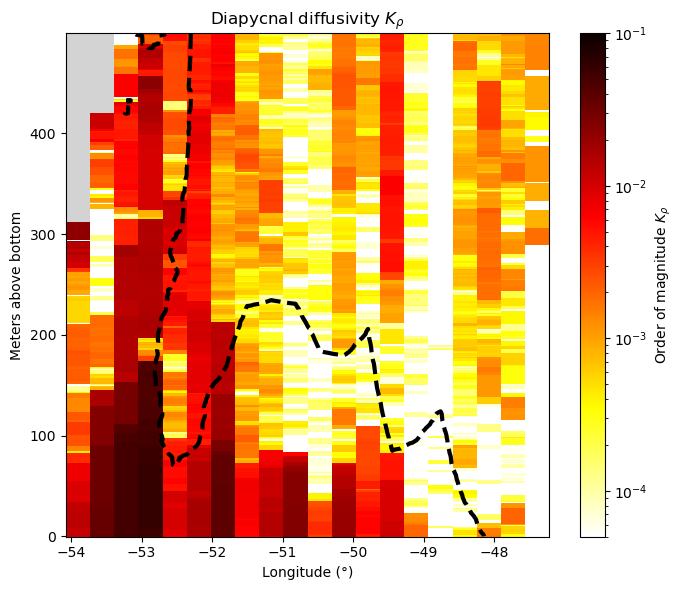

In [52]:
f,a = plt.subplots(nrows = 1, figsize = (7,6), sharex = True)

norm = mcolors.LogNorm(vmin = 5e-5, vmax = 1e-1)
mpp = a.pcolormesh(
    binned_K_df.columns, 
    mab, 
    binned_K_df,
    norm = norm, 
    cmap = "hot_r",
)

a.set_facecolor('lightgrey')
cb = plt.colorbar(mpp, ax = a)
cb.set_label(r"Order of magnitude $K_\rho$")
a.set_xlabel("Longitude (°)")
a.set_title(r"Diapycnal diffusivity $K_\rho$")
a.contour(
    binned_T_df.columns, 
    mab, 
    binned_T_df,
    levels = [-0.7],
    colors = "k",
    linewidths = 3,
)
a.set_ylabel("Meters above bottom")
f.tight_layout()
#f.savefig("./Thorpe_Poster.png", dpi = 800)

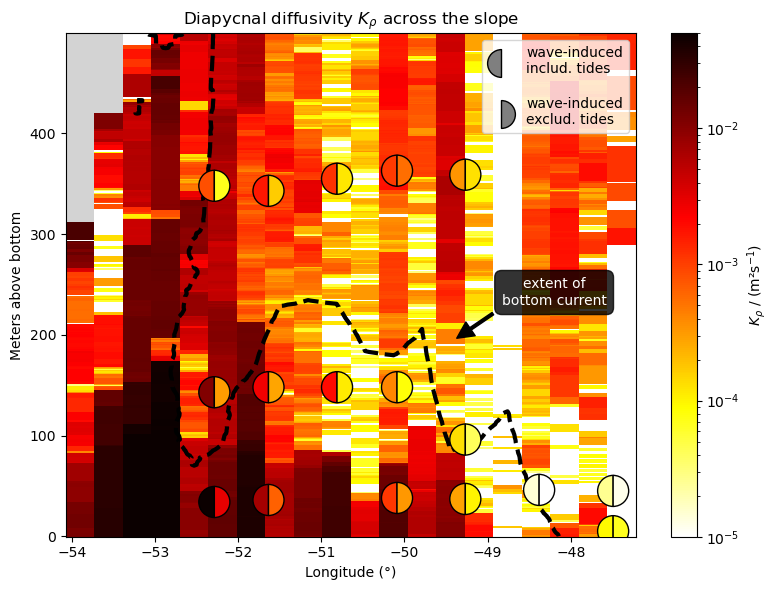

In [53]:
f,a = plt.subplots(nrows = 1, figsize = (8,6), sharex = True)

vmin = BACKGROUND_DIFFUSIVITY
vmax = 5e-2
norm = mcolors.LogNorm(vmin = vmin, vmax = vmax)
mpp = a.pcolormesh(
    binned_K_df.columns, 
    mab, 
    binned_K_df,
    norm = norm, 
    cmap = "hot_r",
)
cb = plt.colorbar(mpp, ax = a)
cb.set_label(r"$K_\rho$ / (m²s$^{-1}$)")

a.contour(
    binned_T_df.columns, 
    mab, 
    binned_T_df,
    levels = [-0.7],
    colors = "k",
    linewidths = 3,
)

from matplotlib.markers import MarkerStyle
a.scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["K_rho"],
    cmap = "hot_r",
    norm = norm,
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="left"),
    s = 500,
    zorder = 10)

a.scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["K_rho_IW"],
    cmap = "hot_r",
    norm = norm,
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="right"),
    s = 500,
    zorder = 10)

a.set_facecolor('lightgrey')
a.set_ylabel("Meters above bottom")
a.set_xlabel("Longitude (°)")
a.set_title(r"Diapycnal diffusivity $K_\rho$ across the slope")


#legend
a.scatter(
    energy_levels["lon"],
    energy_levels["mab"],
    color = "tab:gray",
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="left"),
    s = 400,
    zorder = -10,
    label = "wave-induced\ninclud. tides"
)

a.scatter(
    energy_levels["lon"],
    energy_levels["mab"],
    color = "tab:gray",
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="right"),
    s = 400,
    zorder = -10,
    label = "wave-induced\nexclud. tides"
)
a.legend(labelspacing =1.5)

a.annotate('extent of\nbottom current', xy=(-49.4, 195), xytext=(-48.2, 230),
            arrowprops=dict(facecolor='black', width = 2, shrink=0.05), ha = "center", color = "white", bbox=dict(facecolor='black', alpha = 0.8, edgecolor='black', boxstyle='round, pad = 0.5'))
  
    
f.tight_layout()
#f.savefig("./figures/Conclusion.png", dpi = 300)

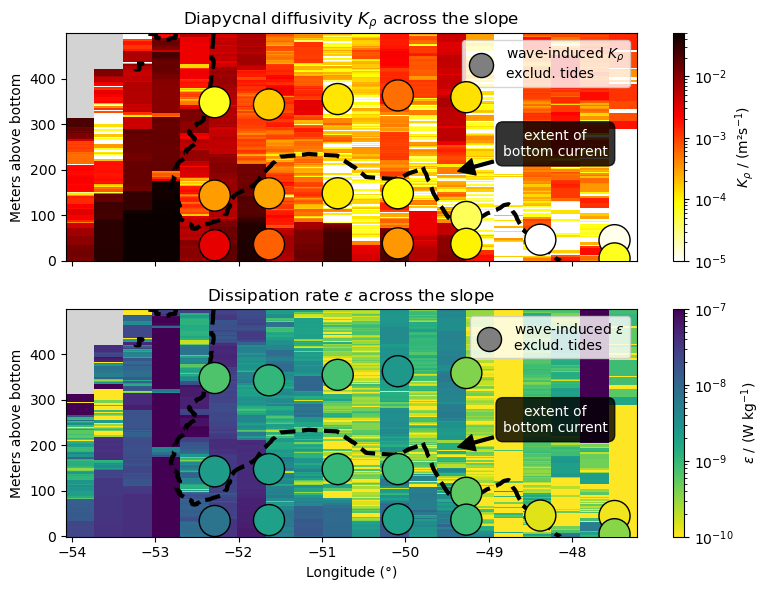

In [54]:
f,a = plt.subplots(nrows = 2, figsize = (8,6), sharex = True)

#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
# Upper subfigure

vmin = BACKGROUND_DIFFUSIVITY
vmax = 5e-2
norm = mcolors.LogNorm(vmin = vmin, vmax = vmax)
mpp = a[0].pcolormesh(
    binned_K_df.columns, 
    mab, 
    binned_K_df,
    norm = norm, 
    cmap = "hot_r",
)
cb = plt.colorbar(mpp, ax = a[0])
cb.set_label(r"$K_\rho$ / (m²s$^{-1}$)")

a[0].contour(
    binned_T_df.columns, 
    mab, 
    binned_T_df,
    levels = [-0.7],
    colors = "k",
    linewidths = 3,
)


a[0].scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["K_rho_IW"],
    cmap = "hot_r",
    norm = norm,
    edgecolor="black",
    marker="o",
    s = 500,
    zorder = 10)

a[0].set_facecolor('lightgrey')
a[0].set_ylabel("Meters above bottom")
#a[0].set_xlabel("Longitude (°)")
a[0].set_title(r"Diapycnal diffusivity $K_\rho$ across the slope")



a[0].scatter(
    energy_levels["lon"],
    energy_levels["mab"],
    color = "tab:gray",
    edgecolor="black",
    marker="o",
    s = 300,
    zorder = -10,
    label = r"wave-induced $K_\rho$"+"\nexclud. tides"
)
a[0].legend(labelspacing =1.5)

a[0].annotate('extent of\nbottom current', xy=(-49.4, 195), xytext=(-48.2, 230),
            arrowprops=dict(facecolor='black', width = 2, shrink=0.05), ha = "center", color = "white", bbox=dict(facecolor='black', alpha = 0.8, edgecolor='black', boxstyle='round, pad = 0.5'))
  

#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
# Lower subfigure

    
vmin = BACKGROUND_DISSIPATION
vmax = 1e-7
norm = mcolors.LogNorm(vmin = vmin, vmax = vmax)
mpp = a[1].pcolormesh(
    binned_eps_df.columns, 
    mab, 
    binned_eps_df,
    norm = norm, 
    cmap = "viridis_r",
)
cb = plt.colorbar(mpp, ax = a[1])
cb.set_label(r"$\varepsilon$ / (W kg$^{-1}$)")

a[1].contour(
    binned_T_df.columns, 
    mab, 
    binned_T_df,
    levels = [-0.7],
    colors = "k",
    linewidths = 3,
)


a[1].scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["eps_IW"],
    cmap = "viridis_r",
    norm = norm,
    edgecolor="black",
    marker="o",
    s = 500,
    zorder = 10)

a[1].set_facecolor('lightgrey')
a[1].set_ylabel("Meters above bottom")
a[1].set_xlabel("Longitude (°)")
a[1].set_title(r"Dissipation rate $\varepsilon$ across the slope")



a[1].scatter(
    energy_levels["lon"],
    energy_levels["mab"],
    color = "tab:gray",
    edgecolor="black",
    marker="o",
    s = 300,
    zorder = -10,
    label = r"wave-induced $\varepsilon$"+"\nexclud. tides"
)
a[1].legend(labelspacing =1.5)

a[1].annotate('extent of\nbottom current', xy=(-49.4, 195), xytext=(-48.2, 230),
            arrowprops=dict(facecolor='black', width = 2, shrink=0.05), ha = "center", color = "white", bbox=dict(facecolor='black', alpha = 0.8, edgecolor='black', boxstyle='round, pad = 0.5'))
  
    
#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
# Save Result

f.tight_layout()
#f.savefig("./figures/Conclusion2.png", dpi = 300)

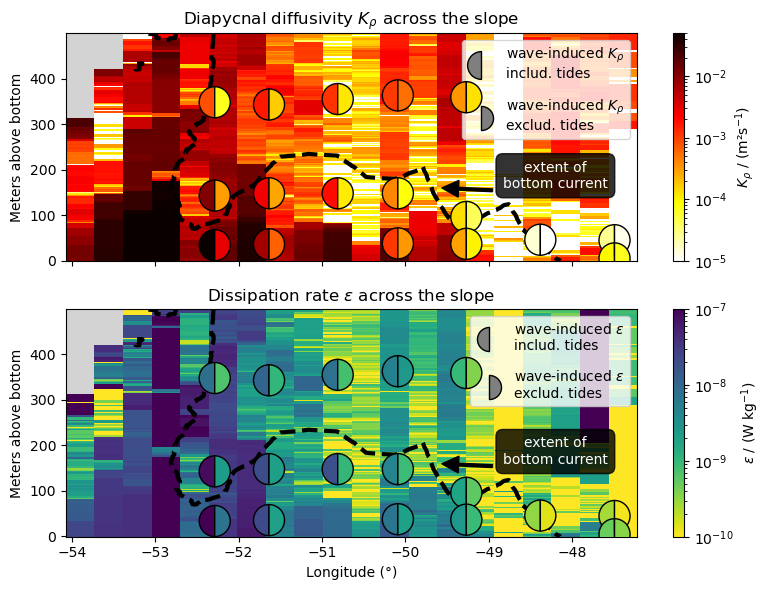

In [55]:
f,a = plt.subplots(nrows = 2, figsize = (8,6), sharex = True)

#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
# Upper subfigure

vmin = BACKGROUND_DIFFUSIVITY
vmax = 5e-2
norm = mcolors.LogNorm(vmin = vmin, vmax = vmax)
mpp = a[0].pcolormesh(
    binned_K_df.columns, 
    mab, 
    binned_K_df,
    norm = norm, 
    cmap = "hot_r",
)
cb = plt.colorbar(mpp, ax = a[0])
cb.set_label(r"$K_\rho$ / (m²s$^{-1}$)")

a[0].contour(
    binned_T_df.columns, 
    mab, 
    binned_T_df,
    levels = [-0.7],
    colors = "k",
    linewidths = 3,
)

a[0].scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["K_rho"],
    cmap = "hot_r",
    norm = norm,
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="left"),
    s = 500,
    zorder = 10)

a[0].scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["K_rho_IW"],
    cmap = "hot_r",
    norm = norm,
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="right"),
    s = 500,
    zorder = 10)


a[0].set_facecolor('lightgrey')
a[0].set_ylabel("Meters above bottom")
#a[0].set_xlabel("Longitude (°)")
a[0].set_title(r"Diapycnal diffusivity $K_\rho$ across the slope")

a[0].scatter(
    energy_levels["lon"],
    energy_levels["mab"],
    color = "tab:gray",
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="left"),
    s = 400,
    zorder = -10,
    label = r"wave-induced $K_\rho$"+"\ninclud. tides"
)

a[0].scatter(
    energy_levels["lon"],
    energy_levels["mab"],
    color = "tab:gray",
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="right"),
    s = 300,
    zorder = -10,
    label = r"wave-induced $K_\rho$"+"\nexclud. tides"
)


a[0].legend(labelspacing = 1.2, loc = "upper right")

a[0].annotate('extent of\nbottom current', xy=(-49.6, 160), xytext=(-48.2, 160),
            arrowprops=dict(facecolor='black', width = 2, shrink=0.05), ha = "center", color = "white", bbox=dict(facecolor='black', alpha = 0.8, edgecolor='black', boxstyle='round, pad = 0.5'))
  

#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
# Lower subfigure

    
vmin = BACKGROUND_DISSIPATION
vmax = 1e-7
norm = mcolors.LogNorm(vmin = vmin, vmax = vmax)
mpp = a[1].pcolormesh(
    binned_eps_df.columns, 
    mab, 
    binned_eps_df,
    norm = norm, 
    cmap = "viridis_r",
)
cb = plt.colorbar(mpp, ax = a[1])
cb.set_label(r"$\varepsilon$ / (W kg$^{-1}$)")

a[1].contour(
    binned_T_df.columns, 
    mab, 
    binned_T_df,
    levels = [-0.7],
    colors = "k",
    linewidths = 3,
)


a[1].scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["eps"],
    cmap = "viridis_r",
    norm = norm,
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="left"),
    s = 500,
    zorder = 10
)

a[1].scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["eps_IW"],
    cmap = "viridis_r",
    norm = norm,
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="right"),
    s = 500,
    zorder = 10
)


a[1].set_facecolor('lightgrey')
a[1].set_ylabel("Meters above bottom")
a[1].set_xlabel("Longitude (°)")
a[1].set_title(r"Dissipation rate $\varepsilon$ across the slope")


a[1].scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    color = "tab:gray",
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="left"),
    s = 300,
    zorder = -10,    
    label = r"wave-induced $\varepsilon$"+"\ninclud. tides"
)

a[1].scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    color = "tab:gray",
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="right"),
    s = 300,
    zorder = -10,
    label = r"wave-induced $\varepsilon$"+"\nexclud. tides"
)


a[1].legend(labelspacing = 1.2, loc = "upper right")

a[1].annotate('extent of\nbottom current', xy=(-49.6, 160), xytext=(-48.2, 160),
            arrowprops=dict(facecolor='black', width = 2, shrink=0.05), ha = "center", color = "white", bbox=dict(facecolor='black', alpha = 0.8, edgecolor='black', boxstyle='round, pad = 0.5'))
  
    
#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
# Save Result

f.tight_layout()
#f.savefig("./figures/Conclusion3.png", dpi = 300)

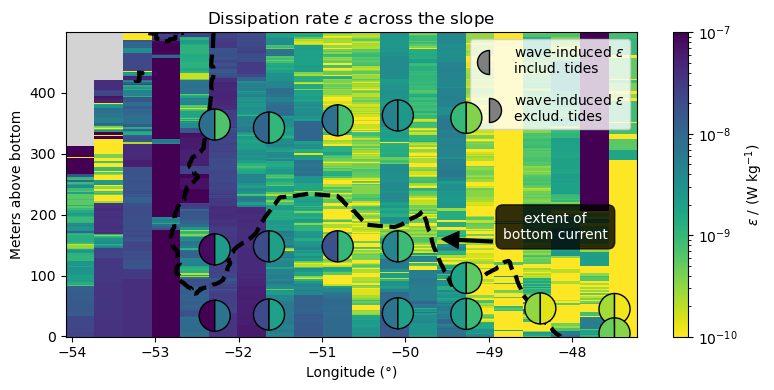

In [59]:
f,ax = plt.subplots(nrows = 1, figsize = (8,4))

#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
    
vmin = BACKGROUND_DISSIPATION
vmax = 1e-7
norm = mcolors.LogNorm(vmin = vmin, vmax = vmax)
mpp = ax.pcolormesh(
    binned_eps_df.columns, 
    mab, 
    binned_eps_df,
    norm = norm, 
    cmap = "viridis_r",
)
cb = plt.colorbar(mpp, ax = ax)
cb.set_label(r"$\varepsilon$ / (W kg$^{-1}$)")

ax.contour(
    binned_T_df.columns, 
    mab, 
    binned_T_df,
    levels = [-0.7],
    colors = "k",
    linewidths = 3,
)


ax.scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["eps"],
    cmap = "viridis_r",
    norm = norm,
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="left"),
    s = 500,
    zorder = 10
)

ax.scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["eps_IW"],
    cmap = "viridis_r",
    norm = norm,
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="right"),
    s = 500,
    zorder = 10
)


ax.set_facecolor('lightgrey')
ax.set_ylabel("Meters above bottom")
ax.set_xlabel("Longitude (°)")
ax.set_title(r"Dissipation rate $\varepsilon$ across the slope")


ax.scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    color = "tab:gray",
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="left"),
    s = 300,
    zorder = -10,    
    label = r"wave-induced $\varepsilon$"+"\ninclud. tides"
)

ax.scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    color = "tab:gray",
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="right"),
    s = 300,
    zorder = -10,
    label = r"wave-induced $\varepsilon$"+"\nexclud. tides"
)


ax.legend(labelspacing = 1.2, loc = "upper right")

ax.annotate('extent of\nbottom current', xy=(-49.6, 160), xytext=(-48.2, 160),
            arrowprops=dict(facecolor='black', width = 2, shrink=0.05), ha = "center", color = "white", bbox=dict(facecolor='black', alpha = 0.8, edgecolor='black', boxstyle='round, pad = 0.5'))
  
    
#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
# Save Result

f.tight_layout()
#f.savefig("./figures/Conclusion3.png", dpi = 300)

In [213]:
def fexp(f):
    return int(np.floor(np.log10(abs(f)))) if f != 0 else 0

def fman(f):
    return f/10**fexp(f)

In [171]:
def generate_pattern(start, end):
    num_steps = (end - start) * 2  # Each step has a multiplier of 1 and 5
    return [multiplier * 10**(start + i // 2) for i, multiplier in enumerate([1, 5] * (num_steps + 1)) if start + i // 2 <= end]

# Example usage:
start_point = -10
end_point = -7

result_list = generate_pattern(start_point, end_point)
print(result_list)


[1e-10, 5e-10, 1e-09, 5e-09, 1e-08, 5e-08, 1e-07, 5e-07]


In [205]:
#mcolors.Colormap('viridis_r').resampled(ncolors)



[1e-10, 5e-10, 1e-09, 5e-09, 1e-08, 5e-08, 1e-07]


/tmp/ipykernel_4267/708960912.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis_r', ncolors)


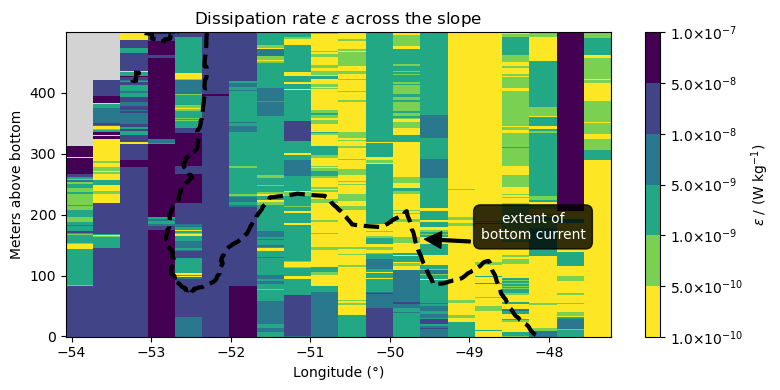

In [206]:
f,ax = plt.subplots(nrows = 1, figsize = (8,4))

#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
start_point = -10
end_point = -7
bounds = generate_pattern(start_point, end_point)[:-1]
print(bounds)
ncolors = len(bounds) - 1
cmap = plt.cm.get_cmap('viridis_r', ncolors)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)

#vmin = BACKGROUND_DISSIPATION
#vmax = 1e-7
#norm = mcolors.LogNorm(vmin = vmin, vmax = vmax)
mpp = ax.pcolormesh(
    binned_eps_df.columns, 
    mab, 
    binned_eps_df,
    norm = norm, 
    cmap = cmap,
)
cb = plt.colorbar(mpp, ax = ax)
cb.set_label(r"$\varepsilon$ / (W kg$^{-1}$)")
cb.ax.set_yticklabels([f'{fman(b):.1f}$\\times10^{{{fexp(b):.0f}}}$' for b in bounds])

ax.contour(
    binned_T_df.columns, 
    mab, 
    binned_T_df,
    levels = [-0.7],
    colors = "k",
    linewidths = 3,
)


ax.annotate('extent of\nbottom current', xy=(-49.6, 160), xytext=(-48.2, 160),
            arrowprops=dict(facecolor='black', width = 2, shrink=0.05), ha = "center", color = "white", bbox=dict(facecolor='black', alpha = 0.8, edgecolor='black', boxstyle='round, pad = 0.5'))
  
ax.set_facecolor('lightgrey')
ax.set_ylabel("Meters above bottom")
ax.set_xlabel("Longitude (°)")
ax.set_title(r"Dissipation rate $\varepsilon$ across the slope")    
#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
# Save Result

f.tight_layout()
f.savefig("./figures/TotalDissipationRate.png", dpi = 300)

[1e-10, 5e-10, 1e-09, 5e-09, 1e-08, 5e-08, 1e-07]


/tmp/ipykernel_4267/1946011069.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis_r', ncolors)


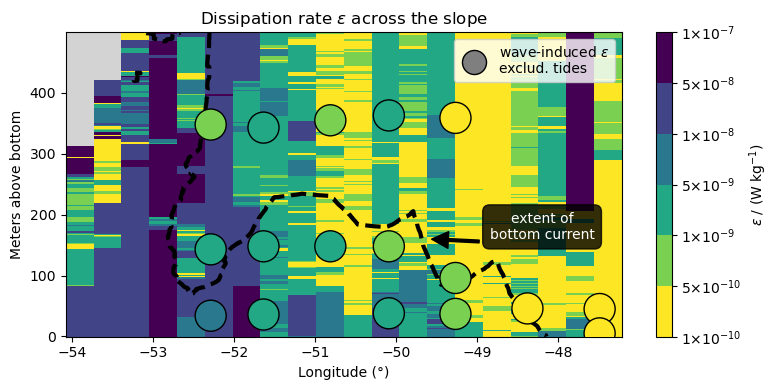

In [212]:
f,ax = plt.subplots(nrows = 1, figsize = (8,4))

#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
start_point = -10
end_point = -7
bounds = generate_pattern(start_point, end_point)[:-1]
print(bounds)
ncolors = len(bounds) - 1
cmap = plt.cm.get_cmap('viridis_r', ncolors)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)

mpp = ax.pcolormesh(
    binned_eps_df.columns, 
    mab, 
    binned_eps_df,
    norm = norm, 
    cmap = cmap,
)
cb = plt.colorbar(mpp, ax = ax)
cb.set_label(r"$\varepsilon$ / (W kg$^{-1}$)")
cb.ax.set_yticklabels([f'{fman(b):.0f}$\\times10^{{{fexp(b):.0f}}}$' for b in bounds])

ax.contour(
    binned_T_df.columns, 
    mab, 
    binned_T_df,
    levels = [-0.7],
    colors = "k",
    linewidths = 3,
)

"""
ax.scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["eps"],
    cmap = "viridis_r",
    norm = norm,
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="left"),
    s = 500,
    zorder = 10
)
"""

ax.scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    c=energy_levels["eps_IW"],
    cmap = cmap,
    norm = norm,
    edgecolor="black",
    marker=MarkerStyle("o"),
    s = 500,
    zorder = 10
)


ax.set_facecolor('lightgrey')
ax.set_ylabel("Meters above bottom")
ax.set_xlabel("Longitude (°)")
ax.set_title(r"Dissipation rate $\varepsilon$ across the slope")

"""
ax.scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    color = "tab:gray",
    edgecolor="black",
    marker=MarkerStyle("o", fillstyle="left"),
    s = 300,
    zorder = -10,    
    label = r"wave-induced $\varepsilon$"+"\ninclud. tides"
)
"""

ax.scatter(
    energy_levels["lon"],
    energy_levels["mab"]+5,
    color = "tab:gray",
    edgecolor="black",
    marker=MarkerStyle("o"),
    s = 300,
    zorder = -10,
    label = r"wave-induced $\varepsilon$"+"\nexclud. tides"
)


ax.legend(labelspacing = 1.2, loc = "upper right")

ax.annotate('extent of\nbottom current', xy=(-49.6, 160), xytext=(-48.2, 160),
            arrowprops=dict(facecolor='black', width = 2, shrink=0.05), ha = "center", color = "white", bbox=dict(facecolor='black', alpha = 0.8, edgecolor='black', boxstyle='round, pad = 0.5'))
  
    
#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
# Save Result

f.tight_layout()
f.savefig("./figures/TotalWaveDissipation.png", dpi = 300)

In [57]:
energy_levels.to_csv("wave_energy_result.csv")